In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from pathlib import Path

In [3]:
import random
import torch
import os
# Seed 고정
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from catboost import CatBoostClassifier, Pool
from collections import defaultdict

## Data Load

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# train = pd.read_csv('/content/drive/MyDrive/2023/F_W/project/HD/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/2023/F_W/project/HD/test.csv')


In [6]:
train[train.columns[train.isnull().any()]].shape

(391939, 8)

In [7]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           391939 non-null  object 
 1   ARI_CO              391939 non-null  object 
 2   ARI_PO              391939 non-null  object 
 3   SHIP_TYPE_CATEGORY  391939 non-null  object 
 4   DIST                391939 non-null  float64
 5   ATA                 391939 non-null  object 
 6   ID                  391939 non-null  object 
 7   BREADTH             391938 non-null  float64
 8   BUILT               391939 non-null  int64  
 9   DEADWEIGHT          391939 non-null  int64  
 10  DEPTH               391938 non-null  float64
 11  DRAUGHT             391938 non-null  float64
 12  GT                  391939 non-null  int64  
 13  LENGTH              391938 non-null  float64
 14  SHIPMANAGER         391939 non-null  object 
 15  FLAG                391939 non-nul

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           220491 non-null  object 
 1   ARI_CO              220491 non-null  object 
 2   ARI_PO              220491 non-null  object 
 3   SHIP_TYPE_CATEGORY  220491 non-null  object 
 4   DIST                220491 non-null  float64
 5   ATA                 220491 non-null  object 
 6   ID                  220491 non-null  object 
 7   BREADTH             220491 non-null  float64
 8   BUILT               220491 non-null  int64  
 9   DEADWEIGHT          220491 non-null  int64  
 10  DEPTH               220491 non-null  float64
 11  DRAUGHT             220491 non-null  float64
 12  GT                  220491 non-null  int64  
 13  LENGTH              220491 non-null  float64
 14  SHIPMANAGER         220491 non-null  object 
 15  FLAG                220491 non-nul

None

In [8]:
display(train[train.columns[train.isnull().any()]].info())
display(test[test.columns[test.isnull().any()]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BREADTH          391938 non-null  float64
 1   DEPTH            391938 non-null  float64
 2   DRAUGHT          391938 non-null  float64
 3   LENGTH           391938 non-null  float64
 4   U_WIND           228251 non-null  float64
 5   V_WIND           228251 non-null  float64
 6   AIR_TEMPERATURE  227309 non-null  float64
 7   BN               228251 non-null  float64
dtypes: float64(8)
memory usage: 23.9 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   U_WIND           128766 non-null  float64
 1   V_WIND           128766 non-null  float64
 2   AIR_TEMPERATURE  128245 non-null  float64
 3   BN               128766 non-null  float64
dtypes: float64(4)
memory usage: 6.7 MB


None

## Data Preprocessing

결측치 처리

BREADTH 와 DEPTH는 ``simpleimputer`` 를 사용하여 평균값으로 대체

In [9]:
from sklearn.impute import SimpleImputer

# 결측값을 중앙값으로 대체하는 SimpleImputer 생성
imputer = SimpleImputer(strategy="mean")

shame = ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'AIR_TEMPERATURE']

train[shame] = imputer.fit_transform(train[shame])
train[shame] = np.round(train[shame])

print(train['BREADTH'].isnull().sum(), train['DEPTH'].isnull().sum(), train['DRAUGHT'].isnull().sum(), train['LENGTH'].isnull().sum())

0 0 0 0


In [10]:
test[shame] = imputer.fit_transform(test[shame])
test[shame] = np.round(test[shame])

#### `U_WIND`, `V_WIND` 결측치 대체
- **`IterativeImputer`** 를 사용하여 결측치 대체

In [11]:
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 대체할 열의 이름을 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time'으로 정의합니다.
wind = ['U_WIND', 'V_WIND']

# IterativeImputer 객체를 생성합니다.
# - Lasso() 추정기(예측 모델)를 사용하여 누락된 값을 대체합니다.
# - 초기 전략은 'most_frequent'로 설정됩니다. (가장 자주 나오는 값으로 초기화)
# - missing_values 매개변수를 사용하여 결측치를 지정합니다.
# - max_iter 매개변수를 사용하여 최대 반복 횟수를 1000으로 설정합니다.
# - imputation_order는 'roman'으로 설정되어 순서대로 대체합니다.
# - random_state는 SEED(임의의 시드 값)로 설정되어 랜덤성을 제어합니다.
imp = IterativeImputer(estimator=Lasso(), initial_strategy='most_frequent', missing_values=np.nan,
                       max_iter=1000, imputation_order='roman', random_state=SEED)

# IterativeImputer를 사용하여 누락된 값을 대체하고, 그 결과를 train 데이터프레임의 해당 열에 할당합니다.
train[wind] = imp.fit_transform(train[wind])

# 대체된 값을 반올림하여 정수로 변환합니다.
#train[estimated_time_col] = np.round(train[estimated_time_col])

# 대체 후에 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time' 열에서 여전히 결측치인 행의 수를 출력합니다.
print(train['V_WIND'].isnull().sum(), train['U_WIND'].isnull().sum())

0 0


In [12]:
test[wind] = imp.fit_transform(test[wind])

`BN` 결측치 대체

![image.png](attachment:image.png)
위 식을 이용하여 BN값 대체

In [13]:
train[['V_WIND', 'U_WIND', 'BN']]

,V_WIND,U_WIND,BN
0,-0.263849,-0.294909,NaN
1,-0.263849,-0.294909,NaN
2,-0.263849,-0.294909,NaN
3,-1.610000,-3.180000,2.629350
4,-3.280000,-0.330000,2.495953
...,...,...,...
391934,-0.263849,-0.294909,NaN
391935,0.970000,-0.660000,1.253491
391936,7.990000,-3.440000,4.766257
391937,-0.263849,-0.294909,NaN


In [14]:
train['BN'].fillna(np.power((abs(train['V_WIND']) / 0.836), 2/3), inplace=True)
test['BN'].fillna(np.power((abs(test['V_WIND']) / 0.836), 2/3), inplace=True)

### Feature Engineering

In [15]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

### `season` 변수 생성

In [16]:
# def Get_Season(x) :
#     if x in [12, 1, 2] :
#         return 'Winter'
#     elif x in [3, 4, 5] :
#         return 'Spring'
#     elif x in [6, 7, 8] :
#         return 'Summer'
#     else :
#         return 'Fall'

# train['Season'] = train['month'].apply(Get_Season)

### `범주형` 변수들 인코딩

In [17]:
from sklearn.preprocessing import OrdinalEncoder

cat_ord = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']

ordinal_encoder = OrdinalEncoder()
train[cat_ord] = ordinal_encoder.fit_transform(train[cat_ord])

In [18]:
test[cat_ord] = ordinal_encoder.fit_transform(test[cat_ord])

In [247]:
cat = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
train[cat]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,ID,SHIPMANAGER,FLAG
0,17.0,21.0,2.0,24710.0,686.0,89.0
1,7.0,81.0,0.0,23140.0,4720.0,74.0
2,4.0,14.0,2.0,19009.0,1370.0,73.0
3,8.0,101.0,2.0,24048.0,3809.0,5.0
4,17.0,21.0,2.0,911.0,1687.0,67.0
...,...,...,...,...,...,...
391934,8.0,66.0,2.0,23490.0,2562.0,20.0
391935,17.0,21.0,0.0,10196.0,2400.0,124.0
391936,21.0,61.0,0.0,8823.0,6106.0,102.0
391937,19.0,35.0,2.0,9246.0,1771.0,22.0


Onehot Encoding

In [248]:
from sklearn.preprocessing import OneHotEncoder

cat_one = ['ARI_CO', 'SHIP_TYPE_CATEGORY']

onehot_encoder = OneHotEncoder(sparse=False)
cat_one_trans= onehot_encoder.fit_transform(train[cat_one])
df_one_hot = pd.DataFrame(cat_one_trans, columns=onehot_encoder.get_feature_names_out())
train = pd.concat([train, df_one_hot], axis=1)


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [249]:
train.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,ARI_CO_19.0,ARI_CO_20.0,ARI_CO_21.0,ARI_CO_22.0,ARI_CO_23.0,ARI_CO_24.0,SHIP_TYPE_CATEGORY_0.0,SHIP_TYPE_CATEGORY_1.0,SHIP_TYPE_CATEGORY_2.0,SHIP_TYPE_CATEGORY_3.0
0,TRAIN_000000,17.0,21.0,2.0,30.881018,24710.0,30.0,24,24300,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRAIN_000001,7.0,81.0,0.0,0.000000,23140.0,30.0,13,35900,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,TRAIN_000002,4.0,14.0,2.0,0.000000,19009.0,50.0,12,146000,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRAIN_000003,8.0,101.0,2.0,0.000000,24048.0,20.0,18,6910,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRAIN_000004,17.0,21.0,2.0,27.037650,911.0,50.0,10,116000,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [250]:
test[cat_ord] = ordinal_encoder.fit_transform(test[cat_ord])

In [251]:
cat_one_trans= onehot_encoder.fit_transform(test[cat_one])
df_one_hot_t = pd.DataFrame(cat_one_trans, columns=onehot_encoder.get_feature_names_out())
test = pd.concat([test, df_one_hot_t], axis=1)

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [252]:
test.shape

(220491, 56)

In [253]:
train.drop(columns=cat_ord, inplace=True)
test.drop(columns=cat_ord, inplace=True)

In [19]:
train.drop(columns='SAMPLE_ID', inplace=True)
test.drop(columns='SAMPLE_ID', inplace=True)

### EDA

## modeling

In [210]:
train_labeled = train[train['CI_HOUR'].notnull()]
train_unlabeled = train[train['CI_HOUR'].isnull()]

train_labeled['CI_HOUR'] = train_labeled['CI_HOUR'].astype('int16')
counts = list(train_labeled['CI_HOUR'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
class_weight_dict = dict(enumerate(class_weight))
print('Weight : ', class_weight)

Weight :  [0.015818788127744367, 0.4149803923569739]


### xgboost

In [24]:
from xgboost import XGBRegressor

In [21]:
X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

Model Tune for XGBSOOT.


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

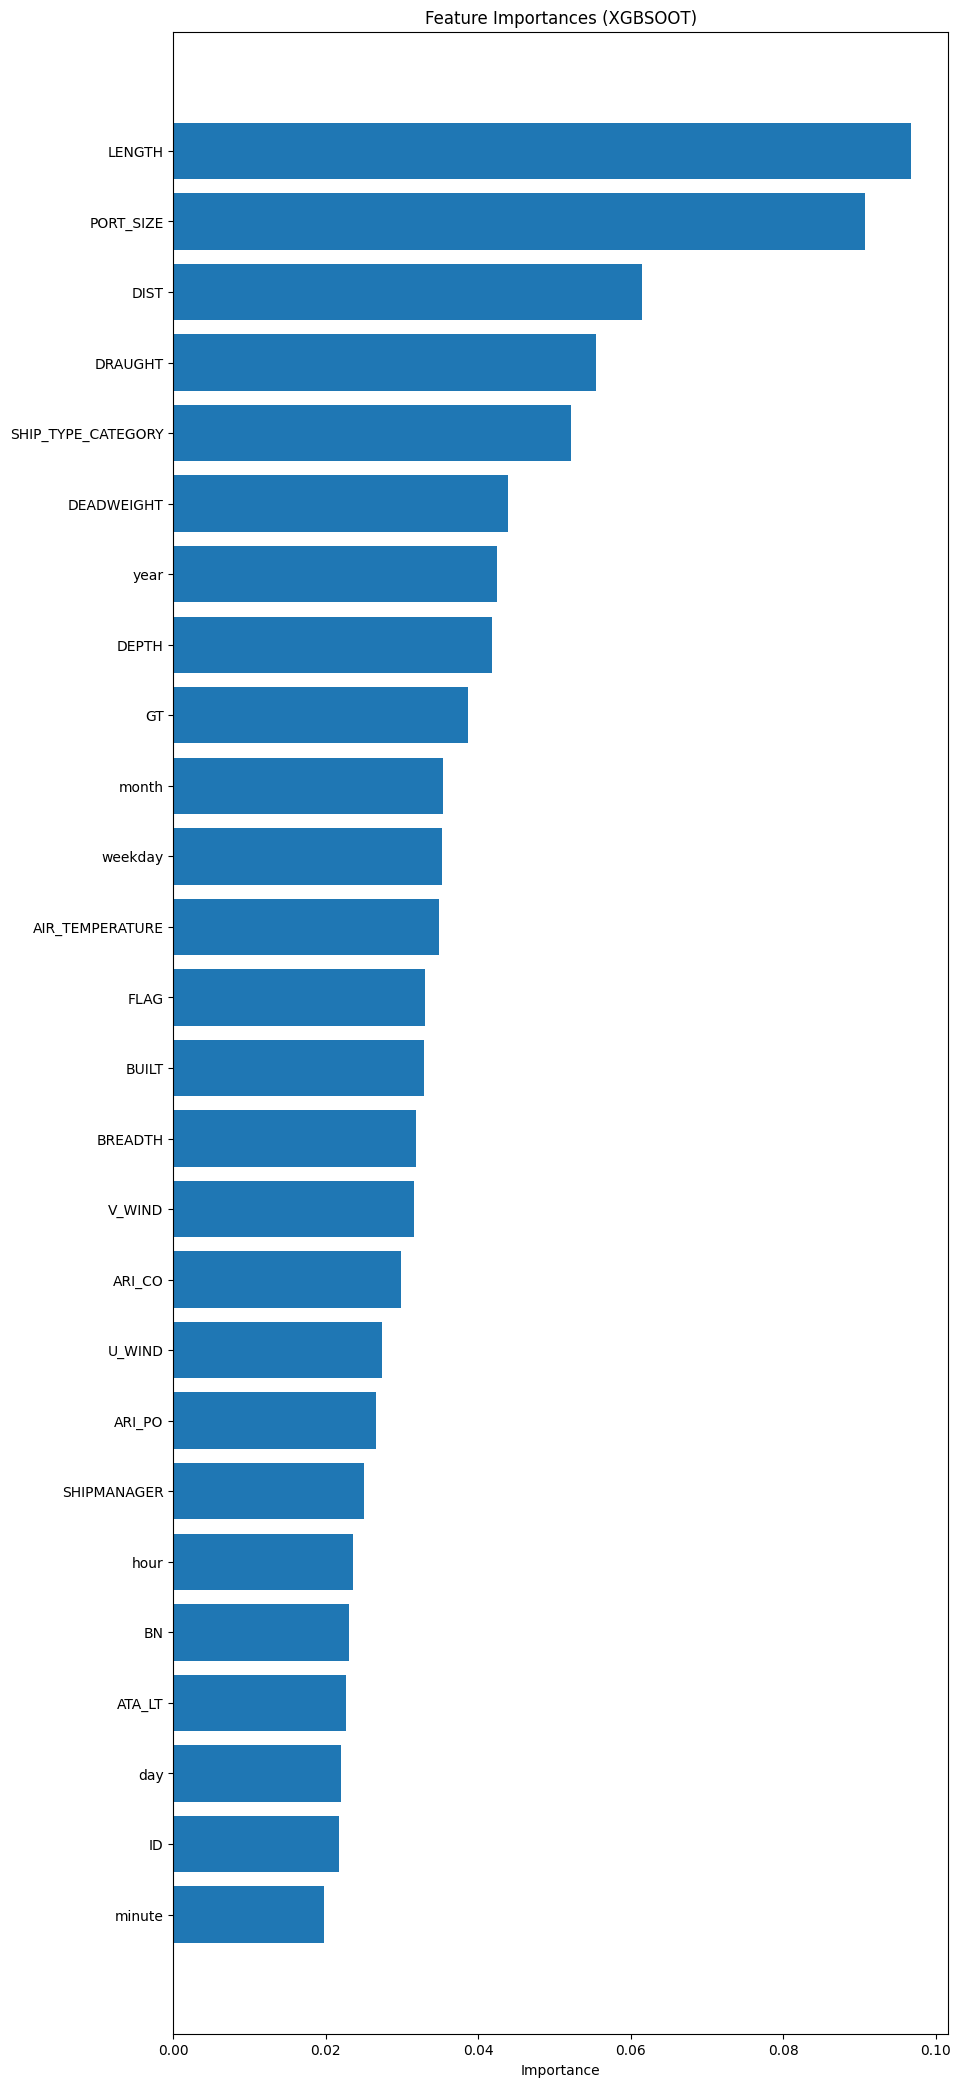

In [25]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']


xgb_model, xgb_feature_importances = train_and_evaluate(XGBRegressor(objective='reg:squarederror', booster='dart', max_depth=10, learning_rate= 0.08879304090462523, n_estimators=3660,
                                                                     subsample=0.9472734999959618, colsample_bytree=0.992432162566946,
                                                                     tree_method='gpu_hist'), 'XGBSOOT', X_train, y_train)

In [22]:
# threshold =  # Your Threshold
# low_importance_features = X_train.columns[xgb_feature_importances < threshold]

X_train_reduced = X_train #.drop(columns=low_importance_features)
X_test_reduced = test #.drop(columns=low_importance_features)

In [231]:
low_importance_features

Index(['ID', 'BN', 'ATA_LT', 'day', 'hour', 'minute'], dtype='object')

In [270]:
X_train_reduced.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'year', 'month', 'day', 'hour', 'minute',
       'weekday'],
      dtype='object')

In [26]:
xgbs = XGBRegressor(objective='reg:squarederror', booster='dart', max_depth=10, learning_rate= 0.08879304090462523, n_estimators=3660,
                                                                     subsample=0.9472734999959618, colsample_bytree=0.992432162566946,
                                                                     tree_method='gpu_hist')

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    xgbs.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgbs.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    mae_scores.append(mean_absolute_error(y_val, val_pred))
    mse_scores.append(mean_squared_error(y_val, val_pred))
    rmse_scores.append(mean_squared_error(y_val, val_pred, squared=False))
    r2_scores.append(r2_score(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    xgbs_pred = xgbs.predict(X_test_reduced)
    xgbs_pred = np.where(xgbs_pred < 0, 0, xgbs_pred)

    ensemble_predictions.append(xgbs_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", mae_scores)
print("Validation : MAE:", np.mean(mae_scores))
print("Validation : MSE:", np.mean(mse_scores))
print("Validation : RMSE:", np.mean(rmse_scores))
print("Validation : R2:", np.mean(r2_scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

Validation : MAE scores for each fold: [56.04049935714854, 57.56644906264427, 57.35624014026003, 56.797590817939344, 56.56745529943153]
Validation : MAE: 56.86564693548475
Validation : MSE: 19776.166544982592
Validation : RMSE: 140.60680581340063
Validation : R2: 0.32228691005732274


In [ ]:
final_predictions

In [1]:
test_df = test

NameError: name 'test' is not defined

In [215]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./xgboost20_submit.csv', index=False)

In [216]:
test_df = test

In [217]:
aa = pd.read_csv('./xgboost20_submit.csv')
qwer = pd.concat([test_df,aa],axis=1)
qwer.loc[qwer['DIST'] == 0, 'CI_HOUR'] = 0
qwer = qwer[['SAMPLE_ID','CI_HOUR']]
qwer.to_csv('./xgboost20_submit_change.csv',index=False)

In [86]:
qwer_1 = pd.read_csv('./xgboost20_submit_change.csv')
qwer_1 = qwer_1[:244989]
qwer_1.to_csv('./xgboost20_submit_change.csv',index=False)

C:\Users\kr937\AppData\Local\Temp\ipykernel_6768\483712676.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  qwer_1 = pd.read_csv('./xgboost20_submit_change.csv')


### Light-BGM

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


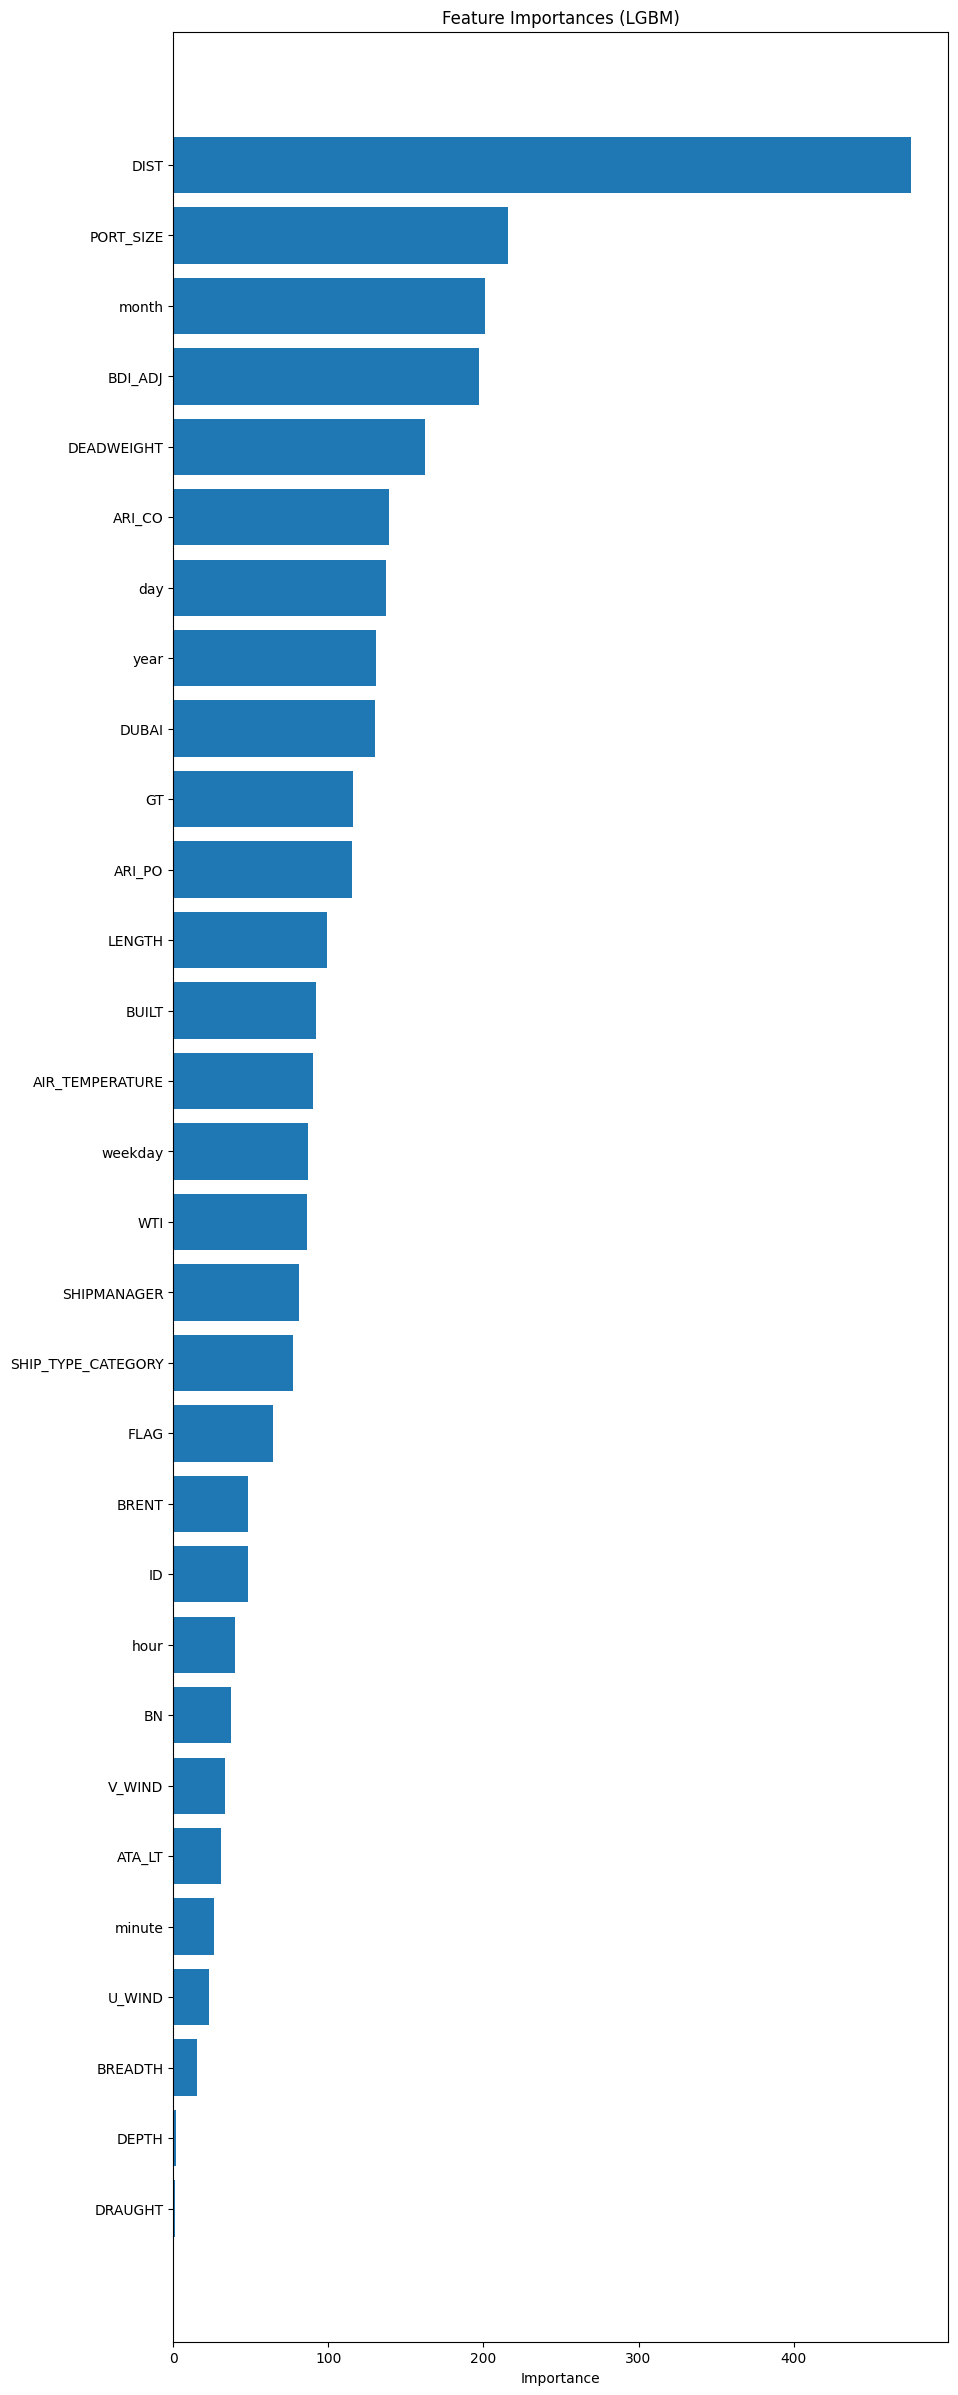

In [339]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [340]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [341]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 16
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:02<00:08,  2.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:04<00:06,  2.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:08<00:02,  2.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

Validation : MAE scores for each fold: [52.868839877855734, 53.716518171456194, 53.66509760758469, 53.814993921759026, 53.27612153713105]
Validation : MAE: 53.468314223157336


In [343]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./aaa3_submit.csv', index=False)

## TUNING

In [19]:
train_labeled = train[train['CI_HOUR'].notnull()]
train_unlabeled = train[train['CI_HOUR'].isnull()]

train_labeled['CI_HOUR'] = train_labeled['CI_HOUR'].astype('int16')
counts = list(train_labeled['CI_HOUR'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
class_weight_dict = dict(enumerate(class_weight))
print('Weight : ', class_weight)

Weight :  [0.015814783870063492, 0.41484211070620863]


In [218]:
X_data, y_data = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2,
                                                      random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(313551, 26) (78388, 26) (313551,) (78388,)


### Gridsearchgrid

In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

parameters = {
    'max_depth': [3, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [1, 5],
    'random_sate':[2],
    'n_thread': [4],
}

xgb_grid = GridSearchCV(xgb, parameters, cv=5, n_jobs=5, verbose=5, scoring='neg_mean_absolute_error')

xgb_grid.fit(X_train, y_train)
scores = pd.DataFrame(xgb_grid.cv_results_)
scores[['params','mean_test_score', 'rank_test_score', 'split0_test_score','split1_test_score', 'split2_test_score']]

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 30
[LightGBM] [Info] Start training from score 61.748823
0:	learn: 167.9830701	total: 145ms	remaining: 2m 24s
1:	learn: 165.6555125	total: 157ms	remaining: 1m 18s
2:	learn: 163.7984245	total: 168ms	remaining: 55.9s
3:	learn: 162.1463543	total: 180ms	remaining: 44.9s
4:	learn: 160.7765905	total: 193ms	remaining: 38.5s
5:	learn: 159.5908625	total: 206ms	remaining: 34.1s
6:	learn: 158.5958743	total: 220ms	remaining: 31.2s
7:	learn: 157.7691587	total: 2

In [98]:
from sklearn.metrics import accuracy_score
xgbBest = xgb_grid.best_estimator_
scores = pd.DataFrame(xgb_grid.cv_results_)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', 21)
scores.info()

print(scores.sort_values(by=scores.columns[20], ascending=True).head(10))

NameError: name 'xgb_grid' is not defined

### optuna

In [219]:
import optuna
import xgboost as xgb
from tqdm import tqdm
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [220]:
X_data, y_data = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2,
                                                      random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(313551, 26) (78388, 26) (313551,) (78388,)


In [222]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method':"gpu_hist",
        'verbosity': 0
    }
    

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=100, verbose=1)
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae


In [223]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)  # 100회의 실험을 수행
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_mae = study.best_value


print("최적 하이퍼파라미터:", best_params)
print("최적 MAE:", best_mae)

[I 2023-10-18 00:16:23,775] A new study created in memory with name: no-name-66df85a3-edb4-40d0-bba9-f6ae176d154d


[0]	validation_0-mae:79.12071	validation_1-mae:78.31505
[1]	validation_0-mae:78.37827	validation_1-mae:77.61088


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:77.69320	validation_1-mae:76.96368
[3]	validation_0-mae:76.79474	validation_1-mae:76.11154
[4]	validation_0-mae:75.37784	validation_1-mae:74.71699
[5]	validation_0-mae:73.98053	validation_1-mae:73.34756
[6]	validation_0-mae:72.95801	validation_1-mae:72.34568
[7]	validation_0-mae:72.46318	validation_1-mae:71.87848
[8]	validation_0-mae:71.36710	validation_1-mae:70.81978
[9]	validation_0-mae:70.21116	validation_1-mae:69.67973
[10]	validation_0-mae:69.68936	validation_1-mae:69.18306
[11]	validation_0-mae:68.77672	validation_1-mae:68.29304
[12]	validation_0-mae:67.93822	validation_1-mae:67.48154
[13]	validation_0-mae:67.60143	validation_1-mae:67.16933
[14]	validation_0-mae:67.29679	validation_1-mae:66.89948
[15]	validation_0-mae:66.54696	validation_1-mae:66.17411
[16]	validation_0-mae:65.85826	validation_1-mae:65.49682
[17]	validation_0-mae:65.63819	validation_1-mae:65.31815
[18]	validation_0-mae:65.36342	validation_1-mae:65.06512
[19]	validation_0-mae:65.25121	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:80.47629	validation_1-mae:79.62802


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:80.28042	validation_1-mae:79.43658
[2]	validation_0-mae:80.13295	validation_1-mae:79.29607
[3]	validation_0-mae:79.92575	validation_1-mae:79.09740
[4]	validation_0-mae:79.61183	validation_1-mae:78.79136
[5]	validation_0-mae:79.28517	validation_1-mae:78.47376
[6]	validation_0-mae:79.01196	validation_1-mae:78.20661
[7]	validation_0-mae:78.87734	validation_1-mae:78.07860
[8]	validation_0-mae:78.59083	validation_1-mae:77.79816
[9]	validation_0-mae:78.26804	validation_1-mae:77.47898
[10]	validation_0-mae:78.09533	validation_1-mae:77.31615
[11]	validation_0-mae:77.81171	validation_1-mae:77.03903
[12]	validation_0-mae:77.53037	validation_1-mae:76.76440
[13]	validation_0-mae:77.38965	validation_1-mae:76.63300
[14]	validation_0-mae:77.26132	validation_1-mae:76.51560
[15]	validation_0-mae:76.99057	validation_1-mae:76.25035
[16]	validation_0-mae:76.73485	validation_1-mae:76.00061
[17]	validation_0-mae:76.47853	validation_1-mae:75.74747
[18]	validation_0-mae:76.35992	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.51959	validation_1-mae:78.67178
[1]	validation_0-mae:78.16567	validation_1-mae:77.32811


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:77.07666	validation_1-mae:76.24499
[3]	validation_0-mae:75.94240	validation_1-mae:75.11684
[4]	validation_0-mae:74.94192	validation_1-mae:74.11969
[5]	validation_0-mae:73.94824	validation_1-mae:73.13396
[6]	validation_0-mae:73.12599	validation_1-mae:72.30847
[7]	validation_0-mae:72.36042	validation_1-mae:71.54293
[8]	validation_0-mae:71.56684	validation_1-mae:70.75236
[9]	validation_0-mae:70.82101	validation_1-mae:70.01533
[10]	validation_0-mae:70.11401	validation_1-mae:69.31257
[11]	validation_0-mae:69.42587	validation_1-mae:68.62730
[12]	validation_0-mae:68.79277	validation_1-mae:67.99721
[13]	validation_0-mae:68.20846	validation_1-mae:67.41723
[14]	validation_0-mae:67.95927	validation_1-mae:67.17392
[15]	validation_0-mae:67.40411	validation_1-mae:66.62387
[16]	validation_0-mae:66.92960	validation_1-mae:66.14280
[17]	validation_0-mae:66.46033	validation_1-mae:65.67019
[18]	validation_0-mae:66.00549	validation_1-mae:65.21859
[19]	validation_0-mae:65.62638	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.66095	validation_1-mae:78.81346
[1]	validation_0-mae:78.44528	validation_1-mae:77.60672
[2]	validation_0-mae:77.42887	validation_1-mae:76.60199
[3]	validation_0-mae:76.80567	validation_1-mae:75.98572
[4]	validation_0-mae:75.87323	validation_1-mae:75.05930
[5]	validation_0-mae:74.92149	validation_1-mae:74.10757
[6]	validation_0-mae:74.12535	validation_1-mae:73.31556
[7]	validation_0-mae:73.37522	validation_1-mae:72.56681
[8]	validation_0-mae:72.59224	validation_1-mae:71.79032
[9]	validation_0-mae:71.85307	validation_1-mae:71.05096


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[10]	validation_0-mae:71.48603	validation_1-mae:70.69149
[11]	validation_0-mae:70.84933	validation_1-mae:70.05764
[12]	validation_0-mae:70.19029	validation_1-mae:69.40234
[13]	validation_0-mae:69.65623	validation_1-mae:68.87101
[14]	validation_0-mae:69.44054	validation_1-mae:68.65988
[15]	validation_0-mae:68.89343	validation_1-mae:68.10954
[16]	validation_0-mae:68.37443	validation_1-mae:67.59142
[17]	validation_0-mae:67.93854	validation_1-mae:67.14336
[18]	validation_0-mae:67.65901	validation_1-mae:66.86591
[19]	validation_0-mae:67.16824	validation_1-mae:66.38303
[20]	validation_0-mae:66.99589	validation_1-mae:66.21556
[21]	validation_0-mae:66.57440	validation_1-mae:65.79817
[22]	validation_0-mae:66.34710	validation_1-mae:65.57568
[23]	validation_0-mae:66.16730	validation_1-mae:65.40592
[24]	validation_0-mae:65.75786	validation_1-mae:65.00120
[25]	validation_0-mae:65.39185	validation_1-mae:64.63217
[26]	validation_0-mae:65.23132	validation_1-mae:64.47389
[27]	validation_0-mae:65.06703	

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:80.13574	validation_1-mae:79.28736
[1]	validation_0-mae:79.42949	validation_1-mae:78.59397
[2]	validation_0-mae:78.75430	validation_1-mae:77.93199
[3]	validation_0-mae:78.09455	validation_1-mae:77.28204
[4]	validation_0-mae:77.51815	validation_1-mae:76.71513


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:76.89549	validation_1-mae:76.09842
[6]	validation_0-mae:76.32037	validation_1-mae:75.53164
[7]	validation_0-mae:75.78132	validation_1-mae:75.00028
[8]	validation_0-mae:75.25841	validation_1-mae:74.48469
[9]	validation_0-mae:74.73039	validation_1-mae:73.96185
[10]	validation_0-mae:74.24131	validation_1-mae:73.47823
[11]	validation_0-mae:73.75848	validation_1-mae:73.00176
[12]	validation_0-mae:73.30088	validation_1-mae:72.54835
[13]	validation_0-mae:72.84827	validation_1-mae:72.09882
[14]	validation_0-mae:72.41136	validation_1-mae:71.66893
[15]	validation_0-mae:71.99985	validation_1-mae:71.26401
[16]	validation_0-mae:71.60342	validation_1-mae:70.87194
[17]	validation_0-mae:71.19467	validation_1-mae:70.46893
[18]	validation_0-mae:70.82501	validation_1-mae:70.10353
[19]	validation_0-mae:70.45218	validation_1-mae:69.73519
[20]	validation_0-mae:70.08222	validation_1-mae:69.36953
[21]	validation_0-mae:69.75043	validation_1-mae:69.04123
[22]	validation_0-mae:69.40056	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.36235	validation_1-mae:78.50359
[1]	validation_0-mae:78.05205	validation_1-mae:77.20391
[2]	validation_0-mae:76.83504	validation_1-mae:76.00643
[3]	validation_0-mae:76.28244	validation_1-mae:75.45570
[4]	validation_0-mae:75.22167	validation_1-mae:74.40706
[5]	validation_0-mae:74.34608	validation_1-mae:73.54022
[6]	validation_0-mae:73.46069	validation_1-mae:72.66959
[7]	validation_0-mae:72.75539	validation_1-mae:71.96052
[8]	validation_0-mae:71.96832	validation_1-mae:71.18034
[9]	validation_0-mae:71.31978	validation_1-mae:70.52138
[10]	validation_0-mae:70.96213	validation_1-mae:70.16646
[11]	validation_0-mae:70.25304	validation_1-mae:69.46227
[12]	validation_0-mae:69.68497	validation_1-mae:68.89464
[13]	validation_0-mae:69.08984	validation_1-mae:68.30758
[14]	validation_0-mae:68.89540	validation_1-mae:68.12379
[15]	validation_0-mae:68.50448	validation_1-mae:67.72928
[16]	validation_0-mae:68.08553	validation_1-mae:67.30854
[17]	validation_0-mae:67.71663	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.23631	validation_1-mae:78.38757
[1]	validation_0-mae:77.62285	validation_1-mae:76.78299
[2]	validation_0-mae:76.18761	validation_1-mae:75.35265
[3]	validation_0-mae:74.82382	validation_1-mae:73.99933
[4]	validation_0-mae:73.67660	validation_1-mae:72.85245
[5]	validation_0-mae:72.62301	validation_1-mae:71.80386
[6]	validation_0-mae:71.74125	validation_1-mae:70.92595
[7]	validation_0-mae:70.87688	validation_1-mae:70.06341
[8]	validation_0-mae:69.96103	validation_1-mae:69.14911
[9]	validation_0-mae:69.17595	validation_1-mae:68.36743
[10]	validation_0-mae:68.50545	validation_1-mae:67.69610
[11]	validation_0-mae:67.78450	validation_1-mae:66.97816
[12]	validation_0-mae:67.14072	validation_1-mae:66.34030
[13]	validation_0-mae:66.53397	validation_1-mae:65.74529
[14]	validation_0-mae:66.25730	validation_1-mae:65.47785
[15]	validation_0-mae:65.73489	validation_1-mae:64.95272
[16]	validation_0-mae:65.27388	validation_1-mae:64.48713
[17]	validation_0-mae:64.82395	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.04553	validation_1-mae:77.26162


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:75.43398	validation_1-mae:74.71941
[2]	validation_0-mae:73.16089	validation_1-mae:72.51529
[3]	validation_0-mae:71.22808	validation_1-mae:70.63508
[4]	validation_0-mae:69.61500	validation_1-mae:69.07409
[5]	validation_0-mae:68.07178	validation_1-mae:67.58512
[6]	validation_0-mae:66.70628	validation_1-mae:66.28245
[7]	validation_0-mae:65.55449	validation_1-mae:65.18157
[8]	validation_0-mae:64.49083	validation_1-mae:64.16384
[9]	validation_0-mae:63.51341	validation_1-mae:63.24148
[10]	validation_0-mae:62.64711	validation_1-mae:62.41850
[11]	validation_0-mae:61.89961	validation_1-mae:61.71173
[12]	validation_0-mae:61.16162	validation_1-mae:61.02378
[13]	validation_0-mae:60.55796	validation_1-mae:60.46851
[14]	validation_0-mae:60.11059	validation_1-mae:60.11120
[15]	validation_0-mae:59.51465	validation_1-mae:59.57049
[16]	validation_0-mae:58.96169	validation_1-mae:59.08651
[17]	validation_0-mae:58.52386	validation_1-mae:58.67678
[18]	validation_0-mae:58.05482	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:80.06345	validation_1-mae:79.21309
[1]	validation_0-mae:79.27458	validation_1-mae:78.43459


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:78.61811	validation_1-mae:77.78252
[3]	validation_0-mae:77.93684	validation_1-mae:77.10793
[4]	validation_0-mae:77.34728	validation_1-mae:76.52425
[5]	validation_0-mae:76.65899	validation_1-mae:75.84648
[6]	validation_0-mae:76.01060	validation_1-mae:75.20807
[7]	validation_0-mae:75.43785	validation_1-mae:74.64330
[8]	validation_0-mae:74.86028	validation_1-mae:74.06998
[9]	validation_0-mae:74.35872	validation_1-mae:73.57136
[10]	validation_0-mae:73.92542	validation_1-mae:73.13779
[11]	validation_0-mae:73.41605	validation_1-mae:72.63316
[12]	validation_0-mae:72.97304	validation_1-mae:72.19451
[13]	validation_0-mae:72.51053	validation_1-mae:71.73952
[14]	validation_0-mae:72.27923	validation_1-mae:71.50968
[15]	validation_0-mae:71.87543	validation_1-mae:71.10561
[16]	validation_0-mae:71.51469	validation_1-mae:70.74005
[17]	validation_0-mae:71.15121	validation_1-mae:70.38321
[18]	validation_0-mae:70.76233	validation_1-mae:70.00030
[19]	validation_0-mae:70.47936	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:80.21216	validation_1-mae:79.36281
[1]	validation_0-mae:79.61235	validation_1-mae:78.77034
[2]	validation_0-mae:79.03578	validation_1-mae:78.19825
[3]	validation_0-mae:78.46761	validation_1-mae:77.63585
[4]	validation_0-mae:77.94995	validation_1-mae:77.12593


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:77.41338	validation_1-mae:76.59659
[6]	validation_0-mae:76.86749	validation_1-mae:76.05842
[7]	validation_0-mae:76.37747	validation_1-mae:75.57531
[8]	validation_0-mae:75.88613	validation_1-mae:75.09158
[9]	validation_0-mae:75.40552	validation_1-mae:74.61608
[10]	validation_0-mae:74.93497	validation_1-mae:74.14991
[11]	validation_0-mae:74.47771	validation_1-mae:73.69498
[12]	validation_0-mae:74.04447	validation_1-mae:73.26851
[13]	validation_0-mae:73.62321	validation_1-mae:72.85078
[14]	validation_0-mae:73.20406	validation_1-mae:72.43449
[15]	validation_0-mae:72.81255	validation_1-mae:72.05238
[16]	validation_0-mae:72.42783	validation_1-mae:71.67067
[17]	validation_0-mae:72.03321	validation_1-mae:71.28383
[18]	validation_0-mae:71.68330	validation_1-mae:70.93642
[19]	validation_0-mae:71.34165	validation_1-mae:70.60002
[20]	validation_0-mae:70.99544	validation_1-mae:70.25818
[21]	validation_0-mae:70.66323	validation_1-mae:69.92950
[22]	validation_0-mae:70.33885	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.80613	validation_1-mae:77.03987
[1]	validation_0-mae:74.99208	validation_1-mae:74.33062
[2]	validation_0-mae:72.56095	validation_1-mae:72.01334
[3]	validation_0-mae:70.54071	validation_1-mae:70.10138
[4]	validation_0-mae:68.83181	validation_1-mae:68.48380


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:67.20798	validation_1-mae:66.96604
[6]	validation_0-mae:65.76578	validation_1-mae:65.61425
[7]	validation_0-mae:64.54028	validation_1-mae:64.48317
[8]	validation_0-mae:63.40581	validation_1-mae:63.44579
[9]	validation_0-mae:62.31675	validation_1-mae:62.44363
[10]	validation_0-mae:61.40138	validation_1-mae:61.60638
[11]	validation_0-mae:60.59186	validation_1-mae:60.87939
[12]	validation_0-mae:59.82687	validation_1-mae:60.18854
[13]	validation_0-mae:59.16030	validation_1-mae:59.60278
[14]	validation_0-mae:58.68049	validation_1-mae:59.29363
[15]	validation_0-mae:58.05612	validation_1-mae:58.73438
[16]	validation_0-mae:57.51779	validation_1-mae:58.27427
[17]	validation_0-mae:57.08100	validation_1-mae:57.90426
[18]	validation_0-mae:56.57638	validation_1-mae:57.46350
[19]	validation_0-mae:56.13031	validation_1-mae:57.11437
[20]	validation_0-mae:55.67173	validation_1-mae:56.74425
[21]	validation_0-mae:55.27945	validation_1-mae:56.43023
[22]	validation_0-mae:54.95805	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.81079	validation_1-mae:77.04567
[1]	validation_0-mae:74.99045	validation_1-mae:74.33541
[2]	validation_0-mae:72.56578	validation_1-mae:72.03752
[3]	validation_0-mae:70.54320	validation_1-mae:70.11290


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[4]	validation_0-mae:68.81562	validation_1-mae:68.49742
[5]	validation_0-mae:67.16522	validation_1-mae:66.93785
[6]	validation_0-mae:65.73760	validation_1-mae:65.60182
[7]	validation_0-mae:64.54220	validation_1-mae:64.48842
[8]	validation_0-mae:63.41175	validation_1-mae:63.44417
[9]	validation_0-mae:62.36694	validation_1-mae:62.51471
[10]	validation_0-mae:61.43470	validation_1-mae:61.64971
[11]	validation_0-mae:60.61356	validation_1-mae:60.91587
[12]	validation_0-mae:59.84341	validation_1-mae:60.23047
[13]	validation_0-mae:59.17768	validation_1-mae:59.64388
[14]	validation_0-mae:58.69966	validation_1-mae:59.31875
[15]	validation_0-mae:58.07499	validation_1-mae:58.75006
[16]	validation_0-mae:57.50531	validation_1-mae:58.27449
[17]	validation_0-mae:57.04129	validation_1-mae:57.88469
[18]	validation_0-mae:56.57520	validation_1-mae:57.47060
[19]	validation_0-mae:56.12900	validation_1-mae:57.14155
[20]	validation_0-mae:55.74230	validation_1-mae:56.83608
[21]	validation_0-mae:55.31849	valida

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.86532	validation_1-mae:77.11549
[1]	validation_0-mae:74.97533	validation_1-mae:74.31359
[2]	validation_0-mae:72.56980	validation_1-mae:72.03556
[3]	validation_0-mae:70.36104	validation_1-mae:69.95501
[4]	validation_0-mae:68.60662	validation_1-mae:68.28843


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:66.93146	validation_1-mae:66.68436
[6]	validation_0-mae:65.47982	validation_1-mae:65.33734
[7]	validation_0-mae:64.25560	validation_1-mae:64.21237
[8]	validation_0-mae:63.05704	validation_1-mae:63.13891
[9]	validation_0-mae:62.05542	validation_1-mae:62.21778
[10]	validation_0-mae:61.18773	validation_1-mae:61.42116
[11]	validation_0-mae:60.38246	validation_1-mae:60.71182
[12]	validation_0-mae:59.60892	validation_1-mae:60.02323
[13]	validation_0-mae:58.95331	validation_1-mae:59.44398
[14]	validation_0-mae:58.49444	validation_1-mae:59.13188
[15]	validation_0-mae:57.86082	validation_1-mae:58.58809
[16]	validation_0-mae:57.32869	validation_1-mae:58.15382
[17]	validation_0-mae:56.89846	validation_1-mae:57.79590
[18]	validation_0-mae:56.39734	validation_1-mae:57.34860
[19]	validation_0-mae:56.00019	validation_1-mae:57.03667
[20]	validation_0-mae:55.61484	validation_1-mae:56.71540
[21]	validation_0-mae:55.22034	validation_1-mae:56.41023
[22]	validation_0-mae:54.91154	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.25878	validation_1-mae:77.47470
[1]	validation_0-mae:75.78195	validation_1-mae:75.08244
[2]	validation_0-mae:73.61800	validation_1-mae:73.03213
[3]	validation_0-mae:71.64518	validation_1-mae:71.15544
[4]	validation_0-mae:70.03382	validation_1-mae:69.63764


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:68.43626	validation_1-mae:68.11615
[6]	validation_0-mae:67.04269	validation_1-mae:66.79062
[7]	validation_0-mae:65.86848	validation_1-mae:65.70761
[8]	validation_0-mae:64.71495	validation_1-mae:64.65804
[9]	validation_0-mae:63.70477	validation_1-mae:63.70456
[10]	validation_0-mae:62.83205	validation_1-mae:62.89936
[11]	validation_0-mae:62.02271	validation_1-mae:62.16942
[12]	validation_0-mae:61.26936	validation_1-mae:61.48546
[13]	validation_0-mae:60.60777	validation_1-mae:60.89300
[14]	validation_0-mae:60.11815	validation_1-mae:60.51159
[15]	validation_0-mae:59.41377	validation_1-mae:59.86571
[16]	validation_0-mae:58.85598	validation_1-mae:59.39124
[17]	validation_0-mae:58.39427	validation_1-mae:58.99040
[18]	validation_0-mae:57.87926	validation_1-mae:58.52932
[19]	validation_0-mae:57.39826	validation_1-mae:58.11484
[20]	validation_0-mae:56.97151	validation_1-mae:57.76184
[21]	validation_0-mae:56.52112	validation_1-mae:57.40045
[22]	validation_0-mae:56.14701	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.42262	validation_1-mae:77.63585
[1]	validation_0-mae:76.04430	validation_1-mae:75.31184
[2]	validation_0-mae:74.03239	validation_1-mae:73.37230
[3]	validation_0-mae:72.12179	validation_1-mae:71.53545
[4]	validation_0-mae:70.60567	validation_1-mae:70.06578
[5]	validation_0-mae:69.11199	validation_1-mae:68.62276


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:67.80417	validation_1-mae:67.35557
[7]	validation_0-mae:66.69328	validation_1-mae:66.28885
[8]	validation_0-mae:65.59023	validation_1-mae:65.26094
[9]	validation_0-mae:64.62395	validation_1-mae:64.32998
[10]	validation_0-mae:63.78883	validation_1-mae:63.53451
[11]	validation_0-mae:62.99416	validation_1-mae:62.77814
[12]	validation_0-mae:62.23101	validation_1-mae:62.06959
[13]	validation_0-mae:61.60674	validation_1-mae:61.48936
[14]	validation_0-mae:61.16582	validation_1-mae:61.12073
[15]	validation_0-mae:60.53813	validation_1-mae:60.54864
[16]	validation_0-mae:60.02925	validation_1-mae:60.08619
[17]	validation_0-mae:59.54272	validation_1-mae:59.64085
[18]	validation_0-mae:59.04157	validation_1-mae:59.17404
[19]	validation_0-mae:58.58528	validation_1-mae:58.76929
[20]	validation_0-mae:58.14622	validation_1-mae:58.38770
[21]	validation_0-mae:57.73586	validation_1-mae:58.02769
[22]	validation_0-mae:57.37690	validation_1-mae:57.70815
[23]	validation_0-mae:57.01114	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.16465	validation_1-mae:77.38685
[1]	validation_0-mae:75.63925	validation_1-mae:74.96608
[2]	validation_0-mae:73.41773	validation_1-mae:72.82483
[3]	validation_0-mae:71.47059	validation_1-mae:70.97893
[4]	validation_0-mae:69.85250	validation_1-mae:69.43657
[5]	validation_0-mae:68.27425	validation_1-mae:67.94027


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:66.92271	validation_1-mae:66.66746
[7]	validation_0-mae:65.75036	validation_1-mae:65.55860
[8]	validation_0-mae:64.59661	validation_1-mae:64.49699
[9]	validation_0-mae:63.56580	validation_1-mae:63.53956
[10]	validation_0-mae:62.60346	validation_1-mae:62.66364
[11]	validation_0-mae:61.77678	validation_1-mae:61.91658
[12]	validation_0-mae:61.02770	validation_1-mae:61.24436
[13]	validation_0-mae:60.38141	validation_1-mae:60.67142
[14]	validation_0-mae:59.88130	validation_1-mae:60.31603
[15]	validation_0-mae:59.25126	validation_1-mae:59.75246
[16]	validation_0-mae:58.69861	validation_1-mae:59.27635
[17]	validation_0-mae:58.18815	validation_1-mae:58.83820
[18]	validation_0-mae:57.69291	validation_1-mae:58.40020
[19]	validation_0-mae:57.21181	validation_1-mae:57.99306
[20]	validation_0-mae:56.80222	validation_1-mae:57.63202
[21]	validation_0-mae:56.36393	validation_1-mae:57.28620
[22]	validation_0-mae:56.01910	validation_1-mae:56.98831
[23]	validation_0-mae:55.73808	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.42055	validation_1-mae:77.63573
[1]	validation_0-mae:76.11069	validation_1-mae:75.39336
[2]	validation_0-mae:74.07781	validation_1-mae:73.41795
[3]	validation_0-mae:72.27050	validation_1-mae:71.66448
[4]	validation_0-mae:70.77157	validation_1-mae:70.20930
[5]	validation_0-mae:69.30006	validation_1-mae:68.78768


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:68.01243	validation_1-mae:67.55024
[7]	validation_0-mae:66.91308	validation_1-mae:66.49477
[8]	validation_0-mae:65.81741	validation_1-mae:65.43982
[9]	validation_0-mae:64.84347	validation_1-mae:64.50813
[10]	validation_0-mae:63.98564	validation_1-mae:63.68746
[11]	validation_0-mae:63.17639	validation_1-mae:62.91920
[12]	validation_0-mae:62.44752	validation_1-mae:62.23290
[13]	validation_0-mae:61.78587	validation_1-mae:61.62091
[14]	validation_0-mae:61.31812	validation_1-mae:61.23944
[15]	validation_0-mae:60.74775	validation_1-mae:60.71839
[16]	validation_0-mae:60.23535	validation_1-mae:60.25122
[17]	validation_0-mae:59.74355	validation_1-mae:59.79921
[18]	validation_0-mae:59.24049	validation_1-mae:59.33922
[19]	validation_0-mae:58.79454	validation_1-mae:58.95247
[20]	validation_0-mae:58.36612	validation_1-mae:58.57990
[21]	validation_0-mae:57.92192	validation_1-mae:58.21958
[22]	validation_0-mae:57.57169	validation_1-mae:57.90947
[23]	validation_0-mae:57.22180	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.31407	validation_1-mae:77.51414
[1]	validation_0-mae:75.91499	validation_1-mae:75.15560
[2]	validation_0-mae:73.82229	validation_1-mae:73.09629
[3]	validation_0-mae:72.00577	validation_1-mae:71.31613
[4]	validation_0-mae:70.52353	validation_1-mae:69.87553
[5]	validation_0-mae:69.09451	validation_1-mae:68.46583
[6]	validation_0-mae:67.81893	validation_1-mae:67.21906
[7]	validation_0-mae:66.74350	validation_1-mae:66.17887


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[8]	validation_0-mae:65.69860	validation_1-mae:65.16500
[9]	validation_0-mae:64.75935	validation_1-mae:64.23960
[10]	validation_0-mae:63.92169	validation_1-mae:63.43097
[11]	validation_0-mae:63.13659	validation_1-mae:62.66955
[12]	validation_0-mae:62.47367	validation_1-mae:62.02879
[13]	validation_0-mae:61.81382	validation_1-mae:61.41621
[14]	validation_0-mae:61.41556	validation_1-mae:61.06283
[15]	validation_0-mae:60.81767	validation_1-mae:60.50940
[16]	validation_0-mae:60.28713	validation_1-mae:60.01323
[17]	validation_0-mae:59.82287	validation_1-mae:59.58493
[18]	validation_0-mae:59.37590	validation_1-mae:59.16876
[19]	validation_0-mae:58.98798	validation_1-mae:58.79680
[20]	validation_0-mae:58.60852	validation_1-mae:58.44572
[21]	validation_0-mae:58.22788	validation_1-mae:58.09046
[22]	validation_0-mae:57.94466	validation_1-mae:57.84259
[23]	validation_0-mae:57.56201	validation_1-mae:57.51318
[24]	validation_0-mae:57.17090	validation_1-mae:57.18874
[25]	validation_0-mae:56.89398	va

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.94463	validation_1-mae:78.10590
[1]	validation_0-mae:77.12213	validation_1-mae:76.30248
[2]	validation_0-mae:75.48928	validation_1-mae:74.68243
[3]	validation_0-mae:73.94774	validation_1-mae:73.15145
[4]	validation_0-mae:72.68668	validation_1-mae:71.90664
[5]	validation_0-mae:71.47782	validation_1-mae:70.70469
[6]	validation_0-mae:70.47618	validation_1-mae:69.70589
[7]	validation_0-mae:69.52309	validation_1-mae:68.76951
[8]	validation_0-mae:68.57502	validation_1-mae:67.83516
[9]	validation_0-mae:67.73370	validation_1-mae:66.99190
[10]	validation_0-mae:66.91054	validation_1-mae:66.17508
[11]	validation_0-mae:66.14606	validation_1-mae:65.40691
[12]	validation_0-mae:65.45352	validation_1-mae:64.72615
[13]	validation_0-mae:64.83429	validation_1-mae:64.12005


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[14]	validation_0-mae:64.47545	validation_1-mae:63.77680
[15]	validation_0-mae:63.87208	validation_1-mae:63.18511
[16]	validation_0-mae:63.40755	validation_1-mae:62.73299
[17]	validation_0-mae:62.96294	validation_1-mae:62.29400
[18]	validation_0-mae:62.48019	validation_1-mae:61.81722
[19]	validation_0-mae:62.06047	validation_1-mae:61.40712
[20]	validation_0-mae:61.63215	validation_1-mae:60.98634
[21]	validation_0-mae:61.24246	validation_1-mae:60.60586
[22]	validation_0-mae:60.86816	validation_1-mae:60.23822
[23]	validation_0-mae:60.53123	validation_1-mae:59.90495
[24]	validation_0-mae:60.19471	validation_1-mae:59.58798
[25]	validation_0-mae:59.94540	validation_1-mae:59.34219
[26]	validation_0-mae:59.73728	validation_1-mae:59.13907
[27]	validation_0-mae:59.57272	validation_1-mae:58.97901
[28]	validation_0-mae:59.30212	validation_1-mae:58.72460
[29]	validation_0-mae:59.07949	validation_1-mae:58.51149
[30]	validation_0-mae:58.97768	validation_1-mae:58.42164
[31]	validation_0-mae:58.72387	

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.02789	validation_1-mae:77.25281
[1]	validation_0-mae:75.38627	validation_1-mae:74.73116
[2]	validation_0-mae:73.07632	validation_1-mae:72.52847
[3]	validation_0-mae:71.06578	validation_1-mae:70.62771
[4]	validation_0-mae:69.39807	validation_1-mae:69.04634


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:67.79397	validation_1-mae:67.51526
[6]	validation_0-mae:66.39197	validation_1-mae:66.19415
[7]	validation_0-mae:65.20908	validation_1-mae:65.10140
[8]	validation_0-mae:64.03240	validation_1-mae:64.00882
[9]	validation_0-mae:62.99761	validation_1-mae:63.06718
[10]	validation_0-mae:62.05054	validation_1-mae:62.19246
[11]	validation_0-mae:61.20231	validation_1-mae:61.41823
[12]	validation_0-mae:60.46365	validation_1-mae:60.75885
[13]	validation_0-mae:59.78119	validation_1-mae:60.16529
[14]	validation_0-mae:59.26503	validation_1-mae:59.80652
[15]	validation_0-mae:58.65413	validation_1-mae:59.26392
[16]	validation_0-mae:58.14241	validation_1-mae:58.82646
[17]	validation_0-mae:57.64442	validation_1-mae:58.40933
[18]	validation_0-mae:57.12903	validation_1-mae:57.96300
[19]	validation_0-mae:56.69033	validation_1-mae:57.59948
[20]	validation_0-mae:56.28634	validation_1-mae:57.24352
[21]	validation_0-mae:55.88171	validation_1-mae:56.95308
[22]	validation_0-mae:55.58262	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.22047	validation_1-mae:77.43159
[1]	validation_0-mae:75.73276	validation_1-mae:75.02190
[2]	validation_0-mae:73.54385	validation_1-mae:72.88890
[3]	validation_0-mae:71.63823	validation_1-mae:71.04393
[4]	validation_0-mae:70.07381	validation_1-mae:69.53473
[5]	validation_0-mae:68.55104	validation_1-mae:68.06005


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:67.22001	validation_1-mae:66.78440
[7]	validation_0-mae:66.11126	validation_1-mae:65.72424
[8]	validation_0-mae:65.00844	validation_1-mae:64.66951
[9]	validation_0-mae:64.03027	validation_1-mae:63.73666
[10]	validation_0-mae:63.10217	validation_1-mae:62.85383
[11]	validation_0-mae:62.29566	validation_1-mae:62.09546
[12]	validation_0-mae:61.57136	validation_1-mae:61.42457
[13]	validation_0-mae:60.93733	validation_1-mae:60.83372
[14]	validation_0-mae:60.48352	validation_1-mae:60.47576
[15]	validation_0-mae:59.93120	validation_1-mae:59.96733
[16]	validation_0-mae:59.44624	validation_1-mae:59.53279
[17]	validation_0-mae:58.99591	validation_1-mae:59.11456
[18]	validation_0-mae:58.51572	validation_1-mae:58.67334
[19]	validation_0-mae:58.04038	validation_1-mae:58.26437
[20]	validation_0-mae:57.62164	validation_1-mae:57.91343
[21]	validation_0-mae:57.25693	validation_1-mae:57.60171
[22]	validation_0-mae:56.96205	validation_1-mae:57.35023
[23]	validation_0-mae:56.63208	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.71474	validation_1-mae:76.96257
[1]	validation_0-mae:74.85954	validation_1-mae:74.22403
[2]	validation_0-mae:72.38676	validation_1-mae:71.87579
[3]	validation_0-mae:70.29326	validation_1-mae:69.88839
[4]	validation_0-mae:68.54085	validation_1-mae:68.24616
[5]	validation_0-mae:66.88526	validation_1-mae:66.66766
[6]	validation_0-mae:65.42633	validation_1-mae:65.32216


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[7]	validation_0-mae:64.12016	validation_1-mae:64.09987
[8]	validation_0-mae:62.99632	validation_1-mae:63.05211
[9]	validation_0-mae:61.95072	validation_1-mae:62.10174
[10]	validation_0-mae:61.01441	validation_1-mae:61.25716
[11]	validation_0-mae:60.19752	validation_1-mae:60.51888
[12]	validation_0-mae:59.46038	validation_1-mae:59.87242
[13]	validation_0-mae:58.80023	validation_1-mae:59.29639
[14]	validation_0-mae:58.22505	validation_1-mae:58.80270
[15]	validation_0-mae:57.71620	validation_1-mae:58.36926
[16]	validation_0-mae:57.20269	validation_1-mae:57.94060
[17]	validation_0-mae:56.75143	validation_1-mae:57.55727
[18]	validation_0-mae:56.37845	validation_1-mae:57.23426
[19]	validation_0-mae:55.96841	validation_1-mae:56.91705
[20]	validation_0-mae:55.61476	validation_1-mae:56.63056
[21]	validation_0-mae:55.22471	validation_1-mae:56.34666
[22]	validation_0-mae:54.82755	validation_1-mae:56.07389
[23]	validation_0-mae:54.40211	validation_1-mae:55.78382
[24]	validation_0-mae:54.01111	val

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.04422	validation_1-mae:77.27917
[1]	validation_0-mae:75.44641	validation_1-mae:74.78684
[2]	validation_0-mae:73.19462	validation_1-mae:72.63416
[3]	validation_0-mae:71.22350	validation_1-mae:70.76971
[4]	validation_0-mae:69.57506	validation_1-mae:69.21808


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:67.97574	validation_1-mae:67.69446
[6]	validation_0-mae:66.56359	validation_1-mae:66.37700
[7]	validation_0-mae:65.33093	validation_1-mae:65.21279
[8]	validation_0-mae:64.22781	validation_1-mae:64.19163
[9]	validation_0-mae:63.17936	validation_1-mae:63.24431
[10]	validation_0-mae:62.24282	validation_1-mae:62.40002
[11]	validation_0-mae:61.42345	validation_1-mae:61.65630
[12]	validation_0-mae:60.68571	validation_1-mae:60.99331
[13]	validation_0-mae:60.00305	validation_1-mae:60.39513
[14]	validation_0-mae:59.37138	validation_1-mae:59.83469
[15]	validation_0-mae:58.82778	validation_1-mae:59.36017
[16]	validation_0-mae:58.31072	validation_1-mae:58.90927
[17]	validation_0-mae:57.76055	validation_1-mae:58.43253
[18]	validation_0-mae:57.33328	validation_1-mae:58.04825
[19]	validation_0-mae:56.88812	validation_1-mae:57.67885
[20]	validation_0-mae:56.53019	validation_1-mae:57.36161
[21]	validation_0-mae:56.10970	validation_1-mae:57.02122
[22]	validation_0-mae:55.79591	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.55871	validation_1-mae:77.75912
[1]	validation_0-mae:76.38323	validation_1-mae:75.64647


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:74.46682	validation_1-mae:73.78769
[3]	validation_0-mae:72.75048	validation_1-mae:72.12337
[4]	validation_0-mae:71.32015	validation_1-mae:70.73663
[5]	validation_0-mae:69.88833	validation_1-mae:69.34934
[6]	validation_0-mae:68.60875	validation_1-mae:68.12660
[7]	validation_0-mae:67.45050	validation_1-mae:67.00692
[8]	validation_0-mae:66.42248	validation_1-mae:66.02094
[9]	validation_0-mae:65.46367	validation_1-mae:65.11051
[10]	validation_0-mae:64.60503	validation_1-mae:64.29110
[11]	validation_0-mae:63.82600	validation_1-mae:63.55690
[12]	validation_0-mae:63.11329	validation_1-mae:62.88635
[13]	validation_0-mae:62.45650	validation_1-mae:62.26624
[14]	validation_0-mae:61.84846	validation_1-mae:61.70453
[15]	validation_0-mae:61.27190	validation_1-mae:61.17479
[16]	validation_0-mae:60.74072	validation_1-mae:60.68330
[17]	validation_0-mae:60.27746	validation_1-mae:60.26068
[18]	validation_0-mae:59.79739	validation_1-mae:59.83240
[19]	validation_0-mae:59.36654	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.07969	validation_1-mae:77.28968
[1]	validation_0-mae:75.48599	validation_1-mae:74.74540


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:73.25054	validation_1-mae:72.54520
[3]	validation_0-mae:71.40293	validation_1-mae:70.74307
[4]	validation_0-mae:69.84464	validation_1-mae:69.22563
[5]	validation_0-mae:68.38167	validation_1-mae:67.79870
[6]	validation_0-mae:67.06381	validation_1-mae:66.50465
[7]	validation_0-mae:65.91108	validation_1-mae:65.37778
[8]	validation_0-mae:64.86421	validation_1-mae:64.35471
[9]	validation_0-mae:63.90883	validation_1-mae:63.42985
[10]	validation_0-mae:63.08796	validation_1-mae:62.63514
[11]	validation_0-mae:62.32221	validation_1-mae:61.89798
[12]	validation_0-mae:61.62438	validation_1-mae:61.25706
[13]	validation_0-mae:60.95439	validation_1-mae:60.63781
[14]	validation_0-mae:60.35296	validation_1-mae:60.09891
[15]	validation_0-mae:59.80379	validation_1-mae:59.58343
[16]	validation_0-mae:59.32258	validation_1-mae:59.15453
[17]	validation_0-mae:58.90988	validation_1-mae:58.78259
[18]	validation_0-mae:58.47213	validation_1-mae:58.39231
[19]	validation_0-mae:58.11039	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.94277	validation_1-mae:77.19028
[1]	validation_0-mae:75.24651	validation_1-mae:74.60443
[2]	validation_0-mae:72.87748	validation_1-mae:72.34155
[3]	validation_0-mae:70.82564	validation_1-mae:70.39259
[4]	validation_0-mae:69.13667	validation_1-mae:68.79468


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[5]	validation_0-mae:67.48404	validation_1-mae:67.23007
[6]	validation_0-mae:66.07641	validation_1-mae:65.90184
[7]	validation_0-mae:64.83973	validation_1-mae:64.75388
[8]	validation_0-mae:63.74051	validation_1-mae:63.74078
[9]	validation_0-mae:62.74488	validation_1-mae:62.83222
[10]	validation_0-mae:61.85608	validation_1-mae:62.02563
[11]	validation_0-mae:61.02720	validation_1-mae:61.28546
[12]	validation_0-mae:60.28626	validation_1-mae:60.63437
[13]	validation_0-mae:59.60431	validation_1-mae:60.03498
[14]	validation_0-mae:58.94491	validation_1-mae:59.45381
[15]	validation_0-mae:58.42531	validation_1-mae:59.00367
[16]	validation_0-mae:57.87463	validation_1-mae:58.53718
[17]	validation_0-mae:57.40406	validation_1-mae:58.12261
[18]	validation_0-mae:56.95557	validation_1-mae:57.73180
[19]	validation_0-mae:56.54491	validation_1-mae:57.38161
[20]	validation_0-mae:56.19297	validation_1-mae:57.07024
[21]	validation_0-mae:55.77095	validation_1-mae:56.75499
[22]	validation_0-mae:55.43299	valid

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.13625	validation_1-mae:77.34548
[1]	validation_0-mae:75.58817	validation_1-mae:74.87980
[2]	validation_0-mae:73.35907	validation_1-mae:72.72538
[3]	validation_0-mae:71.41670	validation_1-mae:70.84159
[4]	validation_0-mae:69.84151	validation_1-mae:69.33064
[5]	validation_0-mae:68.34671	validation_1-mae:67.88654
[6]	validation_0-mae:66.97692	validation_1-mae:66.57927
[7]	validation_0-mae:65.79600	validation_1-mae:65.45217


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[8]	validation_0-mae:64.72860	validation_1-mae:64.44328
[9]	validation_0-mae:63.77887	validation_1-mae:63.53757
[10]	validation_0-mae:62.92840	validation_1-mae:62.73556
[11]	validation_0-mae:62.15571	validation_1-mae:62.02050
[12]	validation_0-mae:61.45295	validation_1-mae:61.36678
[13]	validation_0-mae:60.82910	validation_1-mae:60.78841
[14]	validation_0-mae:60.21500	validation_1-mae:60.22060
[15]	validation_0-mae:59.65532	validation_1-mae:59.70794
[16]	validation_0-mae:59.19202	validation_1-mae:59.27824
[17]	validation_0-mae:58.73067	validation_1-mae:58.85947
[18]	validation_0-mae:58.24578	validation_1-mae:58.45296
[19]	validation_0-mae:57.83754	validation_1-mae:58.10459
[20]	validation_0-mae:57.44402	validation_1-mae:57.76211
[21]	validation_0-mae:57.08579	validation_1-mae:57.46032
[22]	validation_0-mae:56.71642	validation_1-mae:57.16144
[23]	validation_0-mae:56.41547	validation_1-mae:56.89925
[24]	validation_0-mae:56.16610	validation_1-mae:56.69090
[25]	validation_0-mae:55.80131	va

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.30494	validation_1-mae:77.53724
[1]	validation_0-mae:75.91198	validation_1-mae:75.23881
[2]	validation_0-mae:73.79439	validation_1-mae:73.21642
[3]	validation_0-mae:71.91740	validation_1-mae:71.44706
[4]	validation_0-mae:70.35314	validation_1-mae:69.96508
[5]	validation_0-mae:68.81053	validation_1-mae:68.48384


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:67.45982	validation_1-mae:67.20752
[7]	validation_0-mae:66.26506	validation_1-mae:66.08060
[8]	validation_0-mae:65.16893	validation_1-mae:65.05579
[9]	validation_0-mae:64.13205	validation_1-mae:64.10610
[10]	validation_0-mae:63.20304	validation_1-mae:63.25365
[11]	validation_0-mae:62.38306	validation_1-mae:62.50052
[12]	validation_0-mae:61.63398	validation_1-mae:61.82515
[13]	validation_0-mae:60.94973	validation_1-mae:61.22880
[14]	validation_0-mae:60.30136	validation_1-mae:60.65330
[15]	validation_0-mae:59.70662	validation_1-mae:60.13217
[16]	validation_0-mae:59.17163	validation_1-mae:59.67535
[17]	validation_0-mae:58.63674	validation_1-mae:59.19470
[18]	validation_0-mae:58.20404	validation_1-mae:58.81982
[19]	validation_0-mae:57.77055	validation_1-mae:58.45009
[20]	validation_0-mae:57.36351	validation_1-mae:58.08330
[21]	validation_0-mae:56.97170	validation_1-mae:57.76011
[22]	validation_0-mae:56.61390	validation_1-mae:57.46234
[23]	validation_0-mae:56.19661	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.68614	validation_1-mae:77.85979
[1]	validation_0-mae:76.62017	validation_1-mae:75.82375
[2]	validation_0-mae:74.77164	validation_1-mae:74.00042
[3]	validation_0-mae:73.17173	validation_1-mae:72.41803
[4]	validation_0-mae:71.83087	validation_1-mae:71.10469
[5]	validation_0-mae:70.53875	validation_1-mae:69.82786
[6]	validation_0-mae:69.38302	validation_1-mae:68.68486
[7]	validation_0-mae:68.37724	validation_1-mae:67.69586


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[8]	validation_0-mae:67.38371	validation_1-mae:66.72660
[9]	validation_0-mae:66.49467	validation_1-mae:65.84822
[10]	validation_0-mae:65.69247	validation_1-mae:65.06316
[11]	validation_0-mae:64.96581	validation_1-mae:64.35057
[12]	validation_0-mae:64.30809	validation_1-mae:63.70751
[13]	validation_0-mae:63.64747	validation_1-mae:63.05984
[14]	validation_0-mae:63.23919	validation_1-mae:62.68691
[15]	validation_0-mae:62.59034	validation_1-mae:62.05865
[16]	validation_0-mae:62.07540	validation_1-mae:61.55581
[17]	validation_0-mae:61.55805	validation_1-mae:61.05144
[18]	validation_0-mae:61.12040	validation_1-mae:60.63881
[19]	validation_0-mae:60.68987	validation_1-mae:60.22350
[20]	validation_0-mae:60.27211	validation_1-mae:59.81573
[21]	validation_0-mae:59.91685	validation_1-mae:59.47551
[22]	validation_0-mae:59.61651	validation_1-mae:59.19411
[23]	validation_0-mae:59.27285	validation_1-mae:58.89090
[24]	validation_0-mae:58.92817	validation_1-mae:58.58487
[25]	validation_0-mae:58.63671	va

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.04674	validation_1-mae:78.22752
[1]	validation_0-mae:77.29796	validation_1-mae:76.50678
[2]	validation_0-mae:75.70605	validation_1-mae:74.94955


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[3]	validation_0-mae:74.24509	validation_1-mae:73.51782
[4]	validation_0-mae:73.01791	validation_1-mae:72.31474
[5]	validation_0-mae:71.79846	validation_1-mae:71.11730
[6]	validation_0-mae:70.70136	validation_1-mae:70.04215
[7]	validation_0-mae:69.73495	validation_1-mae:69.09931
[8]	validation_0-mae:68.78074	validation_1-mae:68.16889
[9]	validation_0-mae:67.92594	validation_1-mae:67.33658
[10]	validation_0-mae:67.10649	validation_1-mae:66.53425
[11]	validation_0-mae:66.35956	validation_1-mae:65.80491
[12]	validation_0-mae:65.65675	validation_1-mae:65.11379
[13]	validation_0-mae:65.01400	validation_1-mae:64.49083
[14]	validation_0-mae:64.60784	validation_1-mae:64.12163
[15]	validation_0-mae:64.03566	validation_1-mae:63.57362
[16]	validation_0-mae:63.50138	validation_1-mae:63.05967
[17]	validation_0-mae:63.00502	validation_1-mae:62.58854
[18]	validation_0-mae:62.53104	validation_1-mae:62.13156
[19]	validation_0-mae:62.06386	validation_1-mae:61.69129
[20]	validation_0-mae:61.62211	validat

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.93056	validation_1-mae:78.09910
[1]	validation_0-mae:77.13982	validation_1-mae:76.32889


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:75.47624	validation_1-mae:74.67700
[3]	validation_0-mae:74.10647	validation_1-mae:73.31617
[4]	validation_0-mae:72.89674	validation_1-mae:72.11173
[5]	validation_0-mae:71.70882	validation_1-mae:70.92763
[6]	validation_0-mae:70.65435	validation_1-mae:69.88918
[7]	validation_0-mae:69.65590	validation_1-mae:68.90195
[8]	validation_0-mae:68.71397	validation_1-mae:67.97221
[9]	validation_0-mae:67.84684	validation_1-mae:67.12139
[10]	validation_0-mae:67.03615	validation_1-mae:66.31643
[11]	validation_0-mae:66.31544	validation_1-mae:65.60306
[12]	validation_0-mae:65.62486	validation_1-mae:64.90786
[13]	validation_0-mae:65.01581	validation_1-mae:64.31541
[14]	validation_0-mae:64.67153	validation_1-mae:63.98177
[15]	validation_0-mae:64.05959	validation_1-mae:63.37886
[16]	validation_0-mae:63.55791	validation_1-mae:62.87699
[17]	validation_0-mae:63.08065	validation_1-mae:62.41192
[18]	validation_0-mae:62.63435	validation_1-mae:61.96196
[19]	validation_0-mae:62.21700	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.92606	validation_1-mae:77.16301
[1]	validation_0-mae:75.22567	validation_1-mae:74.58064
[2]	validation_0-mae:72.86056	validation_1-mae:72.31575
[3]	validation_0-mae:70.84323	validation_1-mae:70.41305
[4]	validation_0-mae:69.15657	validation_1-mae:68.82148
[5]	validation_0-mae:67.52687	validation_1-mae:67.27706
[6]	validation_0-mae:66.08509	validation_1-mae:65.93171
[7]	validation_0-mae:64.83145	validation_1-mae:64.74137
[8]	validation_0-mae:63.70655	validation_1-mae:63.70000
[9]	validation_0-mae:62.70014	validation_1-mae:62.77604
[10]	validation_0-mae:61.76390	validation_1-mae:61.93898
[11]	validation_0-mae:60.93915	validation_1-mae:61.22108
[12]	validation_0-mae:60.21323	validation_1-mae:60.57344
[13]	validation_0-mae:59.53458	validation_1-mae:59.99715
[14]	validation_0-mae:58.94086	validation_1-mae:59.47538
[15]	validation_0-mae:58.38861	validation_1-mae:58.99198
[16]	validation_0-mae:57.89295	validation_1-mae:58.58586
[17]	validation_0-mae:57.39447	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.08833	validation_1-mae:77.30428


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:75.52712	validation_1-mae:74.82127
[2]	validation_0-mae:73.26833	validation_1-mae:72.63082
[3]	validation_0-mae:71.35419	validation_1-mae:70.77871
[4]	validation_0-mae:69.77575	validation_1-mae:69.27926
[5]	validation_0-mae:68.22956	validation_1-mae:67.77379
[6]	validation_0-mae:66.86971	validation_1-mae:66.45527
[7]	validation_0-mae:65.64570	validation_1-mae:65.28189
[8]	validation_0-mae:64.58639	validation_1-mae:64.26499
[9]	validation_0-mae:63.60549	validation_1-mae:63.35612
[10]	validation_0-mae:62.70531	validation_1-mae:62.51119
[11]	validation_0-mae:61.94896	validation_1-mae:61.79597
[12]	validation_0-mae:61.23843	validation_1-mae:61.14258
[13]	validation_0-mae:60.61550	validation_1-mae:60.57139
[14]	validation_0-mae:60.03352	validation_1-mae:60.03819
[15]	validation_0-mae:59.49378	validation_1-mae:59.53659
[16]	validation_0-mae:58.95135	validation_1-mae:59.06106
[17]	validation_0-mae:58.46568	validation_1-mae:58.64516
[18]	validation_0-mae:57.99050	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.14658	validation_1-mae:77.37028
[1]	validation_0-mae:75.58621	validation_1-mae:74.91743


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:73.37611	validation_1-mae:72.81188
[3]	validation_0-mae:71.39061	validation_1-mae:70.93896
[4]	validation_0-mae:69.76720	validation_1-mae:69.40228
[5]	validation_0-mae:68.18167	validation_1-mae:67.90677
[6]	validation_0-mae:66.80861	validation_1-mae:66.61696
[7]	validation_0-mae:65.63661	validation_1-mae:65.52234
[8]	validation_0-mae:64.46181	validation_1-mae:64.44055
[9]	validation_0-mae:63.43508	validation_1-mae:63.50412
[10]	validation_0-mae:62.50562	validation_1-mae:62.64730
[11]	validation_0-mae:61.66551	validation_1-mae:61.89717
[12]	validation_0-mae:60.90900	validation_1-mae:61.20653
[13]	validation_0-mae:60.23079	validation_1-mae:60.60214
[14]	validation_0-mae:59.72375	validation_1-mae:60.21098
[15]	validation_0-mae:59.12389	validation_1-mae:59.67694
[16]	validation_0-mae:58.57798	validation_1-mae:59.21276
[17]	validation_0-mae:58.10616	validation_1-mae:58.80089
[18]	validation_0-mae:57.64194	validation_1-mae:58.41779
[19]	validation_0-mae:57.16228	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.31439	validation_1-mae:77.53267


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:75.91889	validation_1-mae:75.23706
[2]	validation_0-mae:73.79600	validation_1-mae:73.20310
[3]	validation_0-mae:71.93695	validation_1-mae:71.43235
[4]	validation_0-mae:70.37285	validation_1-mae:69.95149
[5]	validation_0-mae:68.82493	validation_1-mae:68.47573
[6]	validation_0-mae:67.46784	validation_1-mae:67.19780
[7]	validation_0-mae:66.30717	validation_1-mae:66.10324
[8]	validation_0-mae:65.15909	validation_1-mae:65.03971
[9]	validation_0-mae:64.12620	validation_1-mae:64.09839
[10]	validation_0-mae:63.16309	validation_1-mae:63.20783
[11]	validation_0-mae:62.31955	validation_1-mae:62.44072
[12]	validation_0-mae:61.53500	validation_1-mae:61.74331
[13]	validation_0-mae:60.85527	validation_1-mae:61.14162
[14]	validation_0-mae:60.34844	validation_1-mae:60.76415
[15]	validation_0-mae:59.72512	validation_1-mae:60.21730
[16]	validation_0-mae:59.18667	validation_1-mae:59.74658
[17]	validation_0-mae:58.66880	validation_1-mae:59.30629
[18]	validation_0-mae:58.12598	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.82460	validation_1-mae:77.98521
[1]	validation_0-mae:77.13839	validation_1-mae:76.29748


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:75.38682	validation_1-mae:74.55741
[3]	validation_0-mae:73.84525	validation_1-mae:73.02410
[4]	validation_0-mae:72.62434	validation_1-mae:71.81332
[5]	validation_0-mae:71.53937	validation_1-mae:70.73086
[6]	validation_0-mae:70.42254	validation_1-mae:69.61798
[7]	validation_0-mae:69.53739	validation_1-mae:68.73855
[8]	validation_0-mae:68.72054	validation_1-mae:67.91976
[9]	validation_0-mae:68.01094	validation_1-mae:67.20118
[10]	validation_0-mae:67.33558	validation_1-mae:66.52416
[11]	validation_0-mae:66.62433	validation_1-mae:65.81332
[12]	validation_0-mae:66.02135	validation_1-mae:65.21143
[13]	validation_0-mae:65.31879	validation_1-mae:64.50389
[14]	validation_0-mae:64.68839	validation_1-mae:63.86852
[15]	validation_0-mae:64.22072	validation_1-mae:63.39373
[16]	validation_0-mae:63.84156	validation_1-mae:63.01877
[17]	validation_0-mae:63.33976	validation_1-mae:62.51562
[18]	validation_0-mae:62.94986	validation_1-mae:62.12856
[19]	validation_0-mae:62.58124	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.43444	validation_1-mae:77.62713
[1]	validation_0-mae:76.06358	validation_1-mae:75.28294
[2]	validation_0-mae:74.10723	validation_1-mae:73.37467


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[3]	validation_0-mae:72.26010	validation_1-mae:71.57353
[4]	validation_0-mae:70.78741	validation_1-mae:70.13506
[5]	validation_0-mae:69.34452	validation_1-mae:68.71768
[6]	validation_0-mae:68.12237	validation_1-mae:67.53196
[7]	validation_0-mae:67.06152	validation_1-mae:66.50761
[8]	validation_0-mae:65.97450	validation_1-mae:65.45317
[9]	validation_0-mae:65.04438	validation_1-mae:64.54672
[10]	validation_0-mae:64.20327	validation_1-mae:63.72912
[11]	validation_0-mae:63.44439	validation_1-mae:62.98954
[12]	validation_0-mae:62.75802	validation_1-mae:62.33285
[13]	validation_0-mae:62.14782	validation_1-mae:61.75414
[14]	validation_0-mae:61.75373	validation_1-mae:61.42121
[15]	validation_0-mae:61.15015	validation_1-mae:60.85876
[16]	validation_0-mae:60.66027	validation_1-mae:60.39030
[17]	validation_0-mae:60.15313	validation_1-mae:59.91800
[18]	validation_0-mae:59.68131	validation_1-mae:59.48071
[19]	validation_0-mae:59.22407	validation_1-mae:59.05831
[20]	validation_0-mae:58.78531	validat

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.67372	validation_1-mae:77.88198


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:76.66099	validation_1-mae:75.92175
[2]	validation_0-mae:74.81704	validation_1-mae:74.12467
[3]	validation_0-mae:73.28730	validation_1-mae:72.64485
[4]	validation_0-mae:71.91437	validation_1-mae:71.31349
[5]	validation_0-mae:70.56127	validation_1-mae:69.99864
[6]	validation_0-mae:69.32619	validation_1-mae:68.81462
[7]	validation_0-mae:68.19169	validation_1-mae:67.71893
[8]	validation_0-mae:67.18198	validation_1-mae:66.75178
[9]	validation_0-mae:66.24529	validation_1-mae:65.85663
[10]	validation_0-mae:65.39220	validation_1-mae:65.04785
[11]	validation_0-mae:64.61195	validation_1-mae:64.30728
[12]	validation_0-mae:63.91792	validation_1-mae:63.64724
[13]	validation_0-mae:63.25530	validation_1-mae:63.01521
[14]	validation_0-mae:62.63907	validation_1-mae:62.44988
[15]	validation_0-mae:62.05098	validation_1-mae:61.90541
[16]	validation_0-mae:61.50067	validation_1-mae:61.40169
[17]	validation_0-mae:61.01112	validation_1-mae:60.94694
[18]	validation_0-mae:60.54648	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.88546	validation_1-mae:77.11972
[1]	validation_0-mae:75.10935	validation_1-mae:74.47679
[2]	validation_0-mae:72.68729	validation_1-mae:72.17266


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[3]	validation_0-mae:70.59241	validation_1-mae:70.18764
[4]	validation_0-mae:68.88705	validation_1-mae:68.57934
[5]	validation_0-mae:67.25815	validation_1-mae:67.02785
[6]	validation_0-mae:65.82905	validation_1-mae:65.70554
[7]	validation_0-mae:64.62504	validation_1-mae:64.57438
[8]	validation_0-mae:63.46604	validation_1-mae:63.48647
[9]	validation_0-mae:62.41937	validation_1-mae:62.51820
[10]	validation_0-mae:61.47379	validation_1-mae:61.67651
[11]	validation_0-mae:60.65173	validation_1-mae:60.93215
[12]	validation_0-mae:59.91895	validation_1-mae:60.26050
[13]	validation_0-mae:59.25696	validation_1-mae:59.68074
[14]	validation_0-mae:58.77587	validation_1-mae:59.36506
[15]	validation_0-mae:58.21533	validation_1-mae:58.86328
[16]	validation_0-mae:57.64735	validation_1-mae:58.37551
[17]	validation_0-mae:57.12417	validation_1-mae:57.94369
[18]	validation_0-mae:56.66997	validation_1-mae:57.53918
[19]	validation_0-mae:56.22137	validation_1-mae:57.17482
[20]	validation_0-mae:55.86788	validat

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.62571	validation_1-mae:77.86122
[1]	validation_0-mae:76.37761	validation_1-mae:75.65746
[2]	validation_0-mae:74.59027	validation_1-mae:73.92121
[3]	validation_0-mae:73.46602	validation_1-mae:72.87928
[4]	validation_0-mae:71.89931	validation_1-mae:71.36822
[5]	validation_0-mae:70.37437	validation_1-mae:69.89051
[6]	validation_0-mae:69.07133	validation_1-mae:68.65947
[7]	validation_0-mae:67.93234	validation_1-mae:67.56009
[8]	validation_0-mae:66.86559	validation_1-mae:66.55134
[9]	validation_0-mae:65.75787	validation_1-mae:65.50482
[10]	validation_0-mae:65.19924	validation_1-mae:65.04054
[11]	validation_0-mae:64.36432	validation_1-mae:64.24683
[12]	validation_0-mae:63.52689	validation_1-mae:63.45449
[13]	validation_0-mae:62.75161	validation_1-mae:62.73195
[14]	validation_0-mae:62.36434	validation_1-mae:62.43158
[15]	validation_0-mae:61.68886	validation_1-mae:61.81153
[16]	validation_0-mae:61.11821	validation_1-mae:61.28747
[17]	validation_0-mae:60.56940	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.85951	validation_1-mae:77.11234
[1]	validation_0-mae:75.15564	validation_1-mae:74.52828
[2]	validation_0-mae:72.77656	validation_1-mae:72.24892
[3]	validation_0-mae:70.83620	validation_1-mae:70.39946


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[4]	validation_0-mae:69.15291	validation_1-mae:68.80591
[5]	validation_0-mae:67.53515	validation_1-mae:67.27727
[6]	validation_0-mae:66.09743	validation_1-mae:65.92106
[7]	validation_0-mae:64.81865	validation_1-mae:64.72825
[8]	validation_0-mae:63.68014	validation_1-mae:63.68130
[9]	validation_0-mae:62.65926	validation_1-mae:62.73541
[10]	validation_0-mae:61.77537	validation_1-mae:61.95234
[11]	validation_0-mae:60.95742	validation_1-mae:61.20932
[12]	validation_0-mae:60.21155	validation_1-mae:60.55266
[13]	validation_0-mae:59.54690	validation_1-mae:59.98118
[14]	validation_0-mae:58.95638	validation_1-mae:59.46369
[15]	validation_0-mae:58.35191	validation_1-mae:58.93254
[16]	validation_0-mae:57.76534	validation_1-mae:58.45351
[17]	validation_0-mae:57.31728	validation_1-mae:58.08724
[18]	validation_0-mae:56.88810	validation_1-mae:57.73268
[19]	validation_0-mae:56.41900	validation_1-mae:57.34592
[20]	validation_0-mae:55.95578	validation_1-mae:56.96678
[21]	validation_0-mae:55.53727	valida

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.74602	validation_1-mae:76.99002


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[1]	validation_0-mae:74.91453	validation_1-mae:74.27725
[2]	validation_0-mae:72.45427	validation_1-mae:71.93314
[3]	validation_0-mae:70.36209	validation_1-mae:69.95295
[4]	validation_0-mae:68.62799	validation_1-mae:68.32696
[5]	validation_0-mae:66.98745	validation_1-mae:66.77478
[6]	validation_0-mae:65.53863	validation_1-mae:65.43526
[7]	validation_0-mae:64.27002	validation_1-mae:64.24809
[8]	validation_0-mae:63.13308	validation_1-mae:63.18824
[9]	validation_0-mae:62.14823	validation_1-mae:62.29194
[10]	validation_0-mae:61.23680	validation_1-mae:61.45654
[11]	validation_0-mae:60.42985	validation_1-mae:60.73808
[12]	validation_0-mae:59.70233	validation_1-mae:60.11042
[13]	validation_0-mae:59.05364	validation_1-mae:59.54579
[14]	validation_0-mae:58.44970	validation_1-mae:59.03727
[15]	validation_0-mae:57.89323	validation_1-mae:58.55051
[16]	validation_0-mae:57.39503	validation_1-mae:58.14516
[17]	validation_0-mae:56.91816	validation_1-mae:57.73801
[18]	validation_0-mae:56.54423	validatio

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:77.88003	validation_1-mae:77.12857
[1]	validation_0-mae:75.14033	validation_1-mae:74.50068
[2]	validation_0-mae:72.75958	validation_1-mae:72.22963
[3]	validation_0-mae:70.71816	validation_1-mae:70.27936
[4]	validation_0-mae:69.03613	validation_1-mae:68.68462
[5]	validation_0-mae:67.42407	validation_1-mae:67.15203
[6]	validation_0-mae:65.97781	validation_1-mae:65.78618
[7]	validation_0-mae:64.74377	validation_1-mae:64.62498
[8]	validation_0-mae:63.64418	validation_1-mae:63.61152
[9]	validation_0-mae:62.60444	validation_1-mae:62.66227
[10]	validation_0-mae:61.66333	validation_1-mae:61.81419
[11]	validation_0-mae:60.84289	validation_1-mae:61.07602
[12]	validation_0-mae:60.09463	validation_1-mae:60.41810
[13]	validation_0-mae:59.42861	validation_1-mae:59.84674
[14]	validation_0-mae:58.81171	validation_1-mae:59.32653
[15]	validation_0-mae:58.23627	validation_1-mae:58.83664
[16]	validation_0-mae:57.72980	validation_1-mae:58.41564
[17]	validation_0-mae:57.27527	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.22604	validation_1-mae:77.43347
[1]	validation_0-mae:75.75326	validation_1-mae:75.04277


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[2]	validation_0-mae:73.58864	validation_1-mae:72.94133
[3]	validation_0-mae:71.67444	validation_1-mae:71.09005
[4]	validation_0-mae:70.13824	validation_1-mae:69.61089
[5]	validation_0-mae:68.62155	validation_1-mae:68.14053
[6]	validation_0-mae:67.31803	validation_1-mae:66.88766
[7]	validation_0-mae:66.12431	validation_1-mae:65.74895
[8]	validation_0-mae:65.04492	validation_1-mae:64.72799
[9]	validation_0-mae:64.09355	validation_1-mae:63.82565
[10]	validation_0-mae:63.21563	validation_1-mae:63.00012
[11]	validation_0-mae:62.44441	validation_1-mae:62.28648
[12]	validation_0-mae:61.73234	validation_1-mae:61.62176
[13]	validation_0-mae:61.10917	validation_1-mae:61.04117
[14]	validation_0-mae:60.46138	validation_1-mae:60.44033
[15]	validation_0-mae:59.91562	validation_1-mae:59.92888
[16]	validation_0-mae:59.44472	validation_1-mae:59.50160
[17]	validation_0-mae:59.00085	validation_1-mae:59.12039
[18]	validation_0-mae:58.59214	validation_1-mae:58.74890
[19]	validation_0-mae:58.16379	validati

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.21668	validation_1-mae:77.43788
[1]	validation_0-mae:75.73857	validation_1-mae:75.06374
[2]	validation_0-mae:73.55523	validation_1-mae:72.97901
[3]	validation_0-mae:71.62290	validation_1-mae:71.14270
[4]	validation_0-mae:70.01950	validation_1-mae:69.61467
[5]	validation_0-mae:68.44951	validation_1-mae:68.12519


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:67.07495	validation_1-mae:66.85149
[7]	validation_0-mae:65.91935	validation_1-mae:65.77075
[8]	validation_0-mae:64.74440	validation_1-mae:64.67885
[9]	validation_0-mae:63.69463	validation_1-mae:63.71452
[10]	validation_0-mae:62.77692	validation_1-mae:62.86583
[11]	validation_0-mae:61.93030	validation_1-mae:62.10168
[12]	validation_0-mae:61.16913	validation_1-mae:61.40841
[13]	validation_0-mae:60.46789	validation_1-mae:60.79275
[14]	validation_0-mae:59.96440	validation_1-mae:60.41721
[15]	validation_0-mae:59.34965	validation_1-mae:59.88748
[16]	validation_0-mae:58.79307	validation_1-mae:59.39652
[17]	validation_0-mae:58.32526	validation_1-mae:58.98299
[18]	validation_0-mae:57.79590	validation_1-mae:58.51459
[19]	validation_0-mae:57.32005	validation_1-mae:58.11043
[20]	validation_0-mae:56.90042	validation_1-mae:57.72882
[21]	validation_0-mae:56.47918	validation_1-mae:57.39841
[22]	validation_0-mae:56.15527	validation_1-mae:57.14023
[23]	validation_0-mae:55.76083	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.81846	validation_1-mae:78.02098
[1]	validation_0-mae:76.87744	validation_1-mae:76.13088
[2]	validation_0-mae:75.12704	validation_1-mae:74.44143
[3]	validation_0-mae:73.56332	validation_1-mae:72.92996
[4]	validation_0-mae:72.24352	validation_1-mae:71.65643
[5]	validation_0-mae:70.90283	validation_1-mae:70.34732


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[6]	validation_0-mae:69.70775	validation_1-mae:69.19487
[7]	validation_0-mae:68.68063	validation_1-mae:68.21078
[8]	validation_0-mae:67.64381	validation_1-mae:67.21822
[9]	validation_0-mae:66.71196	validation_1-mae:66.33341
[10]	validation_0-mae:65.85795	validation_1-mae:65.50967
[11]	validation_0-mae:65.07976	validation_1-mae:64.76977
[12]	validation_0-mae:64.34193	validation_1-mae:64.06429
[13]	validation_0-mae:63.68890	validation_1-mae:63.44738
[14]	validation_0-mae:63.24803	validation_1-mae:63.07737
[15]	validation_0-mae:62.65957	validation_1-mae:62.52506
[16]	validation_0-mae:62.09316	validation_1-mae:61.98900
[17]	validation_0-mae:61.60833	validation_1-mae:61.54383
[18]	validation_0-mae:61.13733	validation_1-mae:61.10544
[19]	validation_0-mae:60.66774	validation_1-mae:60.66269
[20]	validation_0-mae:60.21604	validation_1-mae:60.24851
[21]	validation_0-mae:59.80837	validation_1-mae:59.88524
[22]	validation_0-mae:59.43258	validation_1-mae:59.54308
[23]	validation_0-mae:59.07605	vali

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.51747	validation_1-mae:77.74208
[1]	validation_0-mae:76.30486	validation_1-mae:75.62108
[2]	validation_0-mae:74.34224	validation_1-mae:73.74649
[3]	validation_0-mae:72.55660	validation_1-mae:72.04551
[4]	validation_0-mae:71.06887	validation_1-mae:70.62876
[5]	validation_0-mae:69.59139	validation_1-mae:69.22311
[6]	validation_0-mae:68.28930	validation_1-mae:67.99324


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[7]	validation_0-mae:67.11000	validation_1-mae:66.88155
[8]	validation_0-mae:66.04466	validation_1-mae:65.88508
[9]	validation_0-mae:65.03680	validation_1-mae:64.95388
[10]	validation_0-mae:64.14814	validation_1-mae:64.12787
[11]	validation_0-mae:63.29032	validation_1-mae:63.35980
[12]	validation_0-mae:62.55217	validation_1-mae:62.68788
[13]	validation_0-mae:61.83252	validation_1-mae:62.02433
[14]	validation_0-mae:61.18015	validation_1-mae:61.43806
[15]	validation_0-mae:60.59089	validation_1-mae:60.91329
[16]	validation_0-mae:60.03784	validation_1-mae:60.42406
[17]	validation_0-mae:59.50563	validation_1-mae:59.94738
[18]	validation_0-mae:59.02197	validation_1-mae:59.53279
[19]	validation_0-mae:58.57852	validation_1-mae:59.15226
[20]	validation_0-mae:58.14043	validation_1-mae:58.78837
[21]	validation_0-mae:57.76338	validation_1-mae:58.46565
[22]	validation_0-mae:57.40384	validation_1-mae:58.14869
[23]	validation_0-mae:57.03392	validation_1-mae:57.84760
[24]	validation_0-mae:56.73599	val

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:79.19555	validation_1-mae:78.35354
[1]	validation_0-mae:77.59399	validation_1-mae:76.76007
[2]	validation_0-mae:76.24096	validation_1-mae:75.41138
[3]	validation_0-mae:75.06031	validation_1-mae:74.23815
[4]	validation_0-mae:73.93095	validation_1-mae:73.11093
[5]	validation_0-mae:72.80172	validation_1-mae:71.98828
[6]	validation_0-mae:71.78450	validation_1-mae:70.97047
[7]	validation_0-mae:70.90367	validation_1-mae:70.09473
[8]	validation_0-mae:70.11669	validation_1-mae:69.30973
[9]	validation_0-mae:69.36111	validation_1-mae:68.55609
[10]	validation_0-mae:68.63155	validation_1-mae:67.82532
[11]	validation_0-mae:68.04104	validation_1-mae:67.23850
[12]	validation_0-mae:67.45617	validation_1-mae:66.64713
[13]	validation_0-mae:66.91124	validation_1-mae:66.10425
[14]	validation_0-mae:66.44776	validation_1-mae:65.63533
[15]	validation_0-mae:65.92135	validation_1-mae:65.11445
[16]	validation_0-mae:65.51604	validation_1-mae:64.70269
[17]	validation_0-mae:65.13582	validation

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[19]	validation_0-mae:64.35488	validation_1-mae:63.53458
[20]	validation_0-mae:64.01561	validation_1-mae:63.19684
[21]	validation_0-mae:63.64477	validation_1-mae:62.82267
[22]	validation_0-mae:63.23413	validation_1-mae:62.40954
[23]	validation_0-mae:62.88943	validation_1-mae:62.06460
[24]	validation_0-mae:62.55065	validation_1-mae:61.73316
[25]	validation_0-mae:62.27386	validation_1-mae:61.45556
[26]	validation_0-mae:61.97747	validation_1-mae:61.15837
[27]	validation_0-mae:61.73577	validation_1-mae:60.92283
[28]	validation_0-mae:61.50124	validation_1-mae:60.68365
[29]	validation_0-mae:61.29153	validation_1-mae:60.47153
[30]	validation_0-mae:61.13026	validation_1-mae:60.31374
[31]	validation_0-mae:60.91890	validation_1-mae:60.10013
[32]	validation_0-mae:60.78588	validation_1-mae:59.96382
[33]	validation_0-mae:60.67328	validation_1-mae:59.85151
[34]	validation_0-mae:60.52646	validation_1-mae:59.70696
[35]	validation_0-mae:60.35122	validation_1-mae:59.52644
[36]	validation_0-mae:60.22830	

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.34426	validation_1-mae:77.55979
[1]	validation_0-mae:75.95673	validation_1-mae:75.27888
[2]	validation_0-mae:73.83464	validation_1-mae:73.26422
[3]	validation_0-mae:71.95046	validation_1-mae:71.45950
[4]	validation_0-mae:70.38395	validation_1-mae:69.96761
[5]	validation_0-mae:68.87079	validation_1-mae:68.53154
[6]	validation_0-mae:67.52015	validation_1-mae:67.25360


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[7]	validation_0-mae:66.37556	validation_1-mae:66.18962
[8]	validation_0-mae:65.22552	validation_1-mae:65.11905
[9]	validation_0-mae:64.19571	validation_1-mae:64.16272
[10]	validation_0-mae:63.26791	validation_1-mae:63.31588
[11]	validation_0-mae:62.41668	validation_1-mae:62.54064
[12]	validation_0-mae:61.65308	validation_1-mae:61.84549
[13]	validation_0-mae:60.97070	validation_1-mae:61.23566
[14]	validation_0-mae:60.49314	validation_1-mae:60.88813
[15]	validation_0-mae:59.88736	validation_1-mae:60.34496
[16]	validation_0-mae:59.33840	validation_1-mae:59.85912
[17]	validation_0-mae:58.81955	validation_1-mae:59.40260
[18]	validation_0-mae:58.30111	validation_1-mae:58.93486
[19]	validation_0-mae:57.87096	validation_1-mae:58.56090
[20]	validation_0-mae:57.43307	validation_1-mae:58.20216
[21]	validation_0-mae:57.06413	validation_1-mae:57.88686
[22]	validation_0-mae:56.72985	validation_1-mae:57.58819
[23]	validation_0-mae:56.41062	validation_1-mae:57.31640
[24]	validation_0-mae:56.05882	val

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[0]	validation_0-mae:78.77854	validation_1-mae:77.96865
[1]	validation_0-mae:76.78380	validation_1-mae:76.01424
[2]	validation_0-mae:74.99317	validation_1-mae:74.26255
[3]	validation_0-mae:73.41198	validation_1-mae:72.70386
[4]	validation_0-mae:72.07782	validation_1-mae:71.39451
[5]	validation_0-mae:70.77538	validation_1-mae:70.11452
[6]	validation_0-mae:69.60667	validation_1-mae:68.97673
[7]	validation_0-mae:68.59857	validation_1-mae:68.00680
[8]	validation_0-mae:67.62535	validation_1-mae:67.06204
[9]	validation_0-mae:66.72260	validation_1-mae:66.18149
[10]	validation_0-mae:65.89044	validation_1-mae:65.36947


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[11]	validation_0-mae:65.09152	validation_1-mae:64.58905
[12]	validation_0-mae:64.39434	validation_1-mae:63.90960
[13]	validation_0-mae:63.75887	validation_1-mae:63.30181
[14]	validation_0-mae:63.33071	validation_1-mae:62.91630
[15]	validation_0-mae:62.76721	validation_1-mae:62.38486
[16]	validation_0-mae:62.23586	validation_1-mae:61.88023
[17]	validation_0-mae:61.74364	validation_1-mae:61.41677
[18]	validation_0-mae:61.23049	validation_1-mae:60.93632
[19]	validation_0-mae:60.77923	validation_1-mae:60.51826
[20]	validation_0-mae:60.34991	validation_1-mae:60.12614
[21]	validation_0-mae:59.94380	validation_1-mae:59.73170
[22]	validation_0-mae:59.59847	validation_1-mae:59.41086
[23]	validation_0-mae:59.25816	validation_1-mae:59.10066
[24]	validation_0-mae:58.94494	validation_1-mae:58.81923
[25]	validation_0-mae:58.66009	validation_1-mae:58.55975
[26]	validation_0-mae:58.37685	validation_1-mae:58.30235
[27]	validation_0-mae:58.11544	validation_1-mae:58.06581
[28]	validation_0-mae:57.89390	

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

최적 하이퍼파라미터: {'booster': 'dart', 'max_depth': 10, 'learning_rate': 0.08879304090462523, 'n_estimators': 3660, 'subsample': 0.9472734999959618, 'colsample_bytree': 0.992432162566946}
최적 MAE: 52.78116226196289
